Import the needed packages and ml modules 

In [1]:
import numpy as np
import pandas as pd

import xarray as xr
import os
import sys

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from  torch.utils.data import TensorDataset
from torchsummary import summary
from sklearn.model_selection import KFold
import torch.nn.functional as F
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline 
import contextily as cx
import folium
import folium.plugins
import pandas as pd
import xarray as xr
import branca
import branca.colormap as cm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-0ph19nk3 because the default path (/home/naveen.raguramalinga/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Read offshore and onshore data

In [2]:
import sys

# Replace 'path_to_directory' with the actual path of the directory containing your Python file
sys.path.append('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/scripts/WC')

import experiment as exp


/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/scripts/WC/experiment.py:37: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(project="naveenragur/ML4Sicily",


https://app.neptune.ai/naveenragur/ML4Sicily/e/MLTSU-264


In [3]:
try:
    MLDir = os.getenv('MLDir')
    SimDir = os.getenv('SimDir')
    reg = 'CT'
    train_size = '3200'
    test_size = '20430'
    mode = 'test'
    mask_size = '3200'
except:
    raise Exception("*** Must first set variable")

# load test events related parameters
event_list_path = f'{MLDir}/data/events/shuffled_events_test_{reg}_{test_size}.txt'
event_list = np.loadtxt(event_list_path, dtype='str')
n_eve = len(event_list)    

flood_mask = ~np.load(f'{MLDir}/data/processed/zero_mask_{reg}_{mask_size}.npy')
zero_mask = np.load(f'{MLDir}/data/processed/zero_mask_{reg}_{mask_size}.npy')
nflood_grids = np.count_nonzero(flood_mask)

# Define the model region related size/architecture
if reg == 'SR':
   GaugeNo = list(range(53,58)) #rough pick for Siracusa
   x_dim = 1300  #lon
   y_dim = 948 #lat
   ts_dim = len(GaugeNo) #no of gauges time series
   reg_gaugeno = str(54)
   control_points = [[37.01,15.29],
      [37.06757,15.28709],
      [37.05266,15.26536],
      [37.03211,15.28632]]
elif reg == 'CT':
   GaugeNo = list(range(35,44)) #for Catania
   x_dim = 912
   y_dim = 2224
   ts_dim = len(GaugeNo)
   reg_gaugeno = str(41)
   control_points =  [[37.5022,15.0960],
      [37.48876,15.08936],
      [37.47193,15.07816],
      [37.46273,15.08527],
      [37.46252,15.08587],
      [37.45312,15.07874],
      [37.42821,15.08506],
      [37.40958,15.08075],
      [37.38595,15.08539],
      [37.35084,15.08575],
      [37.33049,15.07029],]
   
pts = 480

# Load the model inputs for test events
t_array, red_d_array, red_dZ_array = exp.read_memmap(MLDir=MLDir,
                                                      reg=reg,
                                                      train_size=0,
                                                      test_size=test_size,
                                                      ts_dim=ts_dim,
                                                      pts_dim=pts,
                                                      n_eve = n_eve,
                                                      nflood_grids = nflood_grids,
                                                      what4 = mode,
                                                      normalize = False,
                                                      standardize = False)


reading memmap for test data size: 20430


Autoencoder model for offshore to onshore time series

In [4]:
#build the offshore model
class Autoencoder_offshore(nn.Module):
    def __init__(self,
                 ninputs=5, #number of input channels or gauges
                 t_len = 480, #number of time steps
                 ch_list = [32,64,96], #number of channels in each layer
                 zdim = 50):#number of latent variables
        
        super(Autoencoder_offshore, self).__init__()
        # more channels mean more fine details, more resolution 
        # less channel and layers less likely to overfit so better maximas and minimas
        # more accuracy but slower and more memory and data needed to train
        self.ch_list = ch_list

        # define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv1d(ninputs, ch_list[0], kernel_size=3, padding=1),   
            nn.LeakyReLU(negative_slope=0.5,inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(ch_list[0], ch_list[1], kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.5,inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(ch_list[1], ch_list[2], kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.5,inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.1),
            nn.Flatten(),
            nn.Linear(int(t_len*ch_list[-1]/(2**len(ch_list))), zdim),          
        )

        # define decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(zdim,int(t_len*ch_list[-1]/(2**len(ch_list)))),
            nn.Unflatten(1, (ch_list[-1], int(t_len/(2**len(ch_list))))) ,
            nn.ConvTranspose1d(ch_list[2], ch_list[1], kernel_size=4, padding=1, stride= 2),  
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,
            nn.ConvTranspose1d(ch_list[1], ch_list[0], kernel_size=4, padding=1, stride= 2), 
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,
            nn.ConvTranspose1d(ch_list[0], ninputs, kernel_size=4, padding=1, stride= 2), 
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,
        )

    def encode(self, x):
        x = self.encoder(x)
        return x
    
    def decode(self, x):
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        x = self.encode(x)  
        x = self.decode(x)
        return x

#build the onshore model
class Autoencoder_onshore(nn.Module):
    def __init__(self,
                 xy, #number of input channels or grids for flooding
                 zlist = [32,64,128]): #number of channels in each layer
        super(Autoencoder_onshore, self).__init__()
        # more channels mean more fine details, more resolution 
        # less channel and layers less likely to overfit so better maximas and minimas
        # more accuracy but slower and more memory and data needed to train
        self.xy = xy
        
        # define encoder layers
        if len(zlist) == 1:
            self.encoder = nn.Sequential(          
                nn.Linear(xy, zlist[0]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )
            self.decoder = nn.Sequential(
                nn.Linear(zlist[0], xy),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )
        elif len(zlist) == 2:
            self.encoder = nn.Sequential(          
                nn.Linear(xy, zlist[0]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[0], zlist[1]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )
            self.decoder = nn.Sequential(
                nn.Linear(zlist[1], zlist[0]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[0], xy),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )
        elif len(zlist) == 3:
            self.encoder = nn.Sequential(          
                nn.Linear(xy, zlist[0]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[0], zlist[1]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[1], zlist[2]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )
            self.decoder = nn.Sequential(
                nn.Linear(zlist[2], zlist[1]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[1], zlist[0]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[0], xy),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )

    def encode(self, x):
        x = self.encoder(x)
        return x
    
    def decode(self, x):
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        x = self.encode(x)  
        x = self.decode(x)
        return x

#build the coupled model
class Autoencoder_coupled(nn.Module):
    def __init__(self,
                offshore_model,
                onshore_model,
                deform_model,
                interface_layers,
                tune_layer):
        super(Autoencoder_coupled, self).__init__()

        # Pretrained offshore 
        self.offshore_encoder = offshore_model.encoder
        for i, layer in enumerate(self.offshore_encoder):
            if i < len(self.offshore_encoder) - tune_layer: #all layers except last
                for param in layer.parameters():
                    param.requires_grad = False
            else:
                for param in layer.parameters(): #last layer
                    param.requires_grad = True

        # Pretrained deform 
        self.deform_encoder = deform_model.encoder
        for i, layer in enumerate(self.deform_encoder):
            if i < len(self.deform_encoder) - tune_layer: #all layers except last
                for param in layer.parameters():
                    param.requires_grad = False
            else:
                for param in layer.parameters(): #last layer
                    param.requires_grad = True

        # Interface
        if interface_layers == 1:
            self.connect = nn.Sequential(
                                nn.Linear(
                                    in_features=64, out_features=64
                                ),
                                nn.ReLU(),
            ) 
        elif interface_layers == 2:    
            self.connect = nn.Sequential(
                                    nn.Linear(
                                        in_features=64, out_features=64
                                    ),
                                    nn.LeakyReLU(inplace=True),
                                    nn.Linear(
                                        in_features=64, out_features=64
                                    ),
                                    nn.LeakyReLU(inplace=True),
            )
        # Pretrained onshore model
        self.onshore_decoder = onshore_model.decoder 
        for i, layer in enumerate(self.onshore_decoder):
            if i < tune_layer:
                for param in layer.parameters(): #first layer
                    param.requires_grad = True
            else:
                for param in layer.parameters(): #all layers except first
                    param.requires_grad = False

    def forward(self, x, dz):
        x = self.offshore_encoder(x)
        # dz = self.deform_encoder(dz)
        # x = torch.cat((x, dz), dim=1)
        # x = self.connect(x)
        # x = torch.sub(x, dz)
        x = self.onshore_decoder(x)
        return x

In [5]:
exp.set_seed_settings(0)

z = 64
channels_off = [64,128,256]
channels_on = [64,64]
channels_deform = [64,64]

exp.run.stop() #stop neptune run and sync files

cuda is: False
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 9 operations to synchronize with Neptune. Do not kill this process.
All 9 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/naveenragur/ML4Sicily/e/MLTSU-264/metadata


In [6]:
def Gfit(obs, pred): #a normalized least-squares per event in first dimensions
    print('obs shape', obs.shape,len(obs))
    Gtable = np.zeros(len(obs))
    for i in range(len(obs)):      
        obs_i = np.array(obs[i])
        pred_i = np.array(pred[i])
        Gvaluei = 1 - (2*np.sum(obs_i*pred_i)/(np.sum(obs_i**2)+np.sum(pred_i**2)))
        Gtable[i] = Gvaluei
    return Gtable

In [7]:
# def Gfit(obs, pred):
#     obs = np.array(obs)  # Convert the input lists to NumPy arrays
#     pred = np.array(pred)
    
#     numerator = 2 * np.sum(obs * pred, axis=1)
#     denominator = np.sum(obs**2, axis=1) + np.sum(pred**2, axis=1)
    
#     Gtable = 1 - (numerator / denominator)
    
#     return Gtable

In [8]:
def Gfit_one(obs, pred): #a normalized least-squares
    obs = np.array(obs)
    pred = np.array(pred)
    Gvalue = 1 - (2*np.sum(obs*pred)/(np.sum(obs**2)+np.sum(pred**2)))
    return Gvalue

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 480]           1,792
         LeakyReLU-2              [-1, 64, 480]               0
         AvgPool1d-3              [-1, 64, 240]               0
            Conv1d-4             [-1, 128, 240]          24,704
         LeakyReLU-5             [-1, 128, 240]               0
         AvgPool1d-6             [-1, 128, 120]               0
            Conv1d-7             [-1, 256, 120]          98,560
         LeakyReLU-8             [-1, 256, 120]               0
         AvgPool1d-9              [-1, 256, 60]               0
          Dropout-10              [-1, 256, 60]               0
          Flatten-11                [-1, 15360]               0
           Linear-12                   [-1, 64]         983,104
           Linear-13                [-1, 15360]         998,400
        Unflatten-14              [-1, 

obs shape torch.Size([20430, 4320]) 20430
R2 score above 0.7: 20197
Gfit score below 0.1: 19283


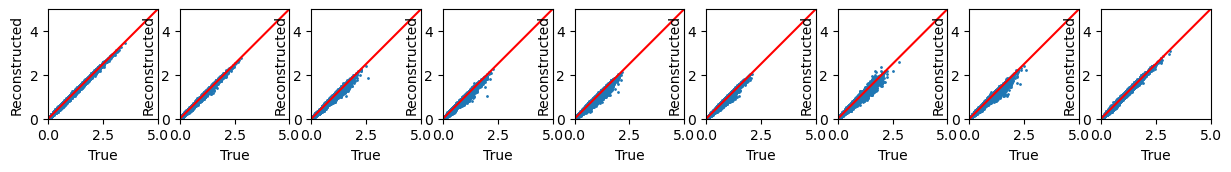

Text(0, 0.5, 'Score')

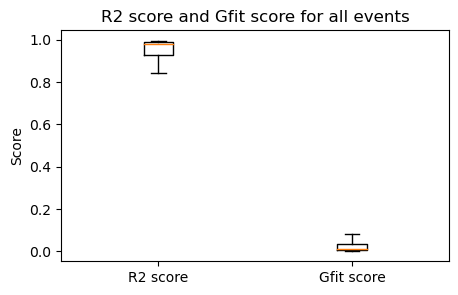

In [9]:
offshore_model = torch.load(f"{MLDir}/model/{reg}/out/model_offshore_ch_{channels_off}_minepoch_{train_size}.pt", map_location=torch.device('cpu'))

# Test model for final evaluation
#read model from file for testing
model = offshore_model
model.eval()
summary(model,(ts_dim,pts))
criterion = nn.MSELoss()
print(t_array.shape)
test_dataset = torch.tensor(t_array, dtype=torch.float32).to('cpu')
print(test_dataset.shape)
with torch.no_grad():
    recon_data = model(test_dataset)
tloss = criterion(recon_data, test_dataset)
print(f"Test loss: {tloss :.5f}", end="\r")

recon_data = recon_data[:, :, :].cpu().detach().numpy()

# Flatten the tables along the n_gauge and n_time axes to get 2D arrays (neve, n_gauge * n_time)
flat_table1 = test_dataset.reshape(test_dataset.shape[0],-1)
flat_table2 = recon_data.reshape(recon_data.shape[0],-1)
Gfit_off = Gfit(flat_table1, flat_table2)

# Compute the R2 score for each event
flat_table1 = np.transpose(flat_table1)
flat_table2 = np.transpose(flat_table2)
r2_scores_off = r2_score(flat_table1, flat_table2, multioutput='raw_values')

#count events with score above 0.7
print('R2 score above 0.7:',np.sum(r2_scores_off > 0.65))
print('Gfit score below 0.1:',np.sum(Gfit_off < 0.1))

#plot per gauge
plt.figure(figsize=(15, 3))
for g in range(9):
    plt.subplot(1, 9, g+1)
    plt.scatter(t_array[:, g, :].max(axis=1), recon_data[:, g, :].max(axis=1), s=1)
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    plt.xlabel('True')
    plt.ylabel('Reconstructed')
plt.show()

#plot r2 /gfit score as box plot
plt.figure(figsize=(5,3))
# Create the first box plot for R2 scores
positions = [1, 2]
plt.boxplot(r2_scores_off, showfliers=False, positions=[positions[0]])
# Create the second box plot for Gfit scores
plt.boxplot(Gfit_off, showfliers=False, positions=[positions[1]])
plt.gca().set_xticks(positions)
plt.gca().set_xticklabels(['R2 score', 'Gfit score'])

plt.title('R2 score and Gfit score for all events')
plt.ylabel('Score')



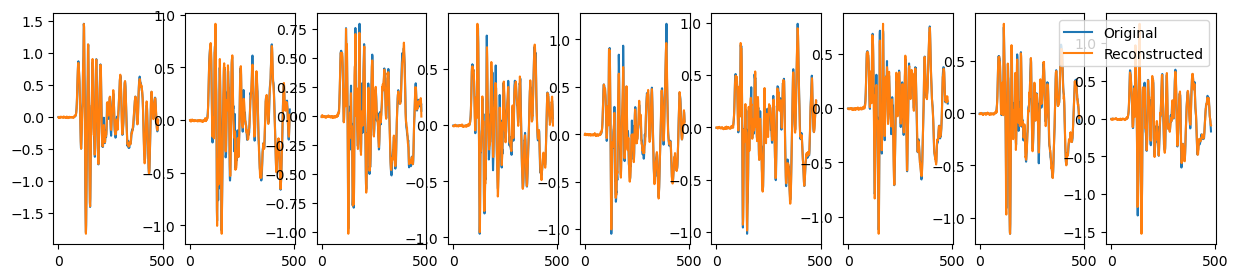

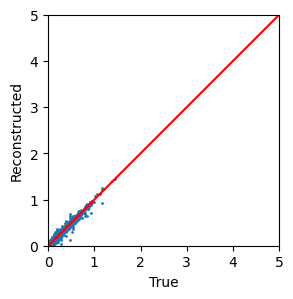

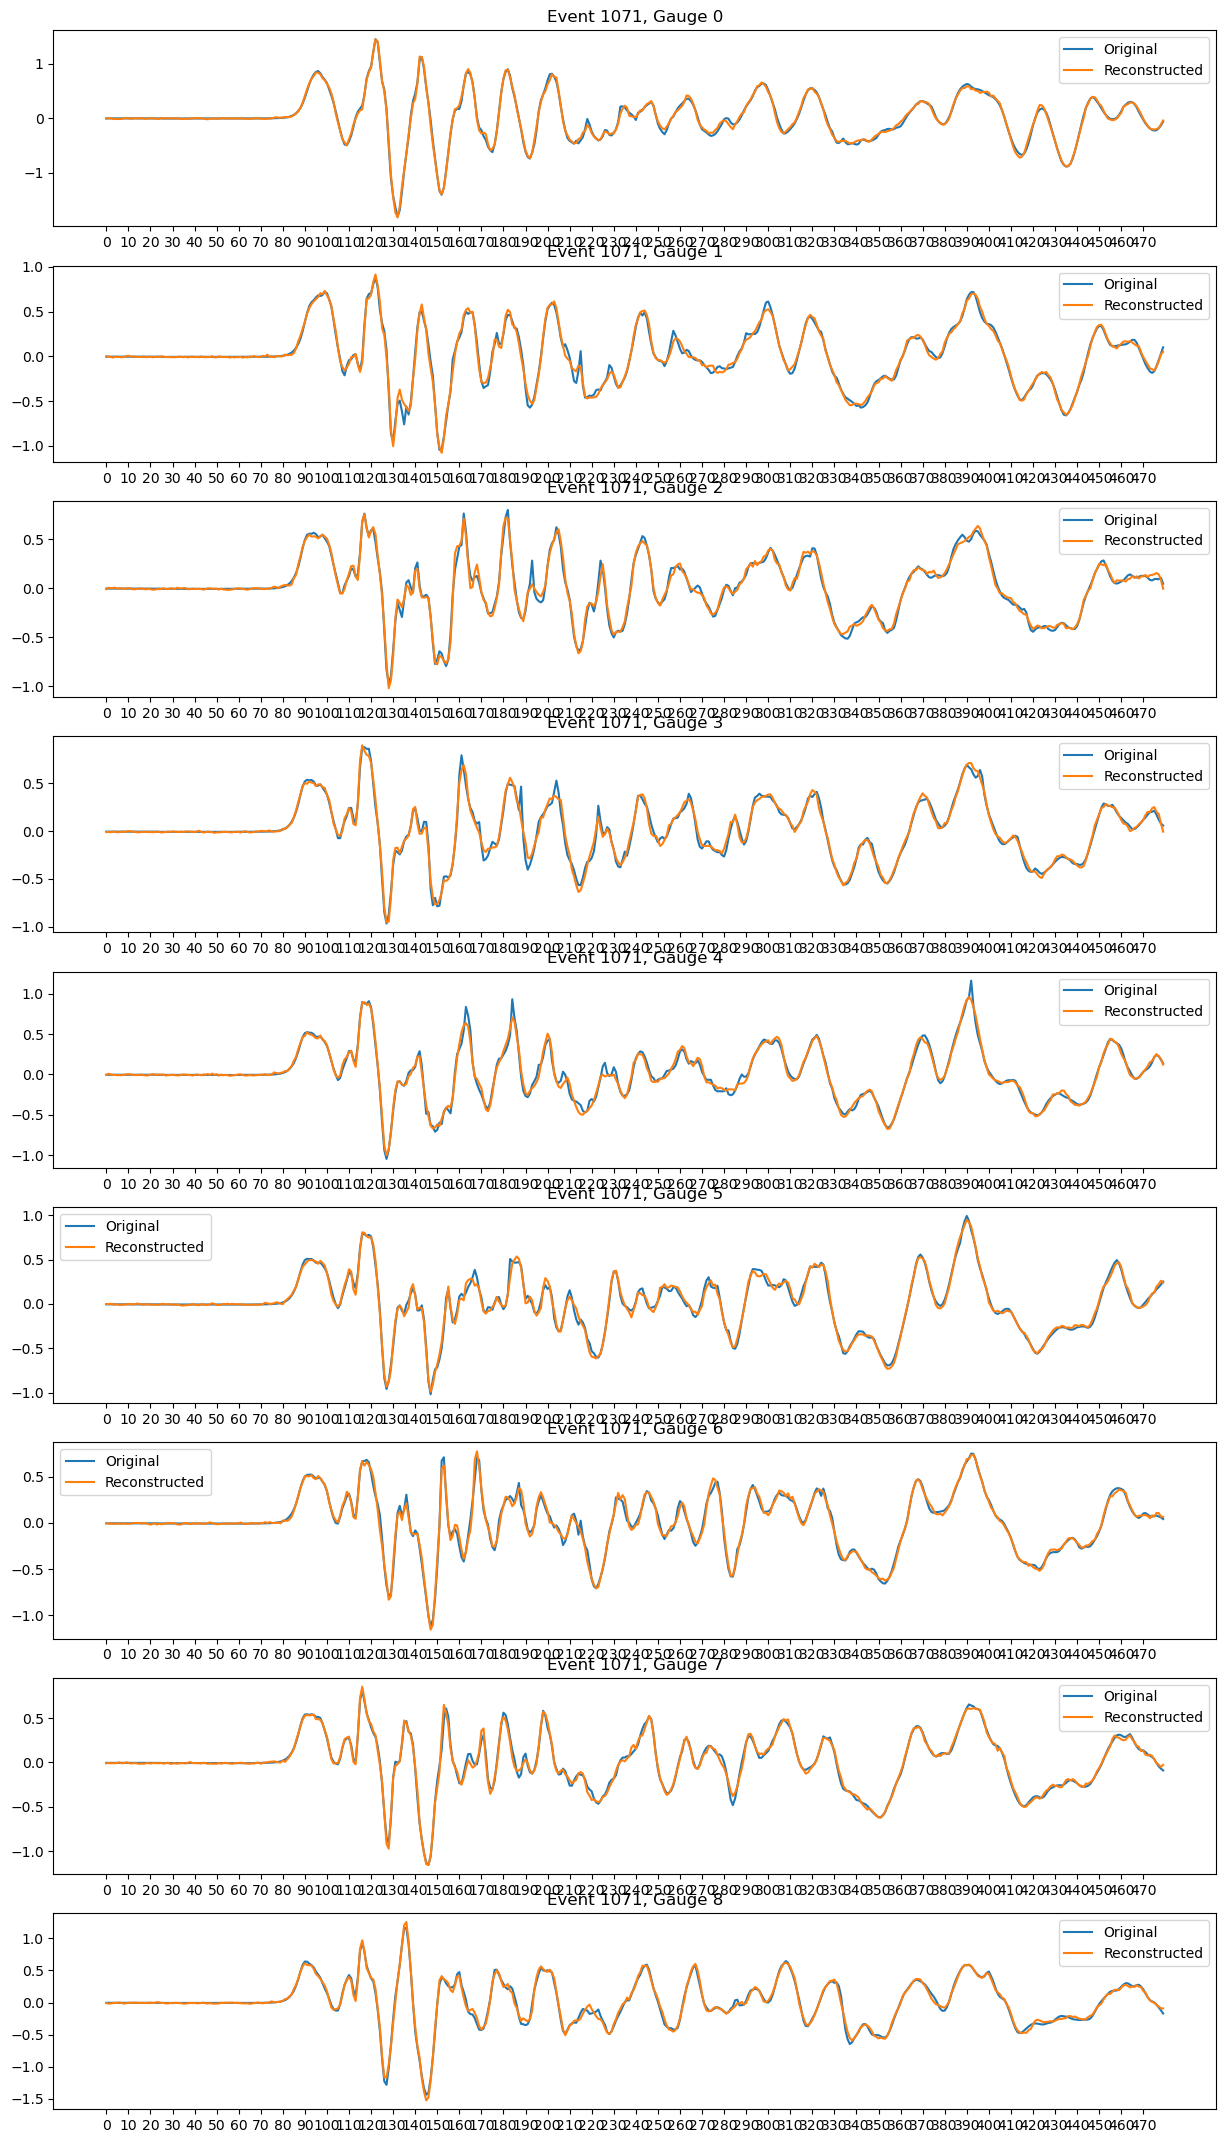

In [11]:
# Plot results all gauge
eve_no = 1071
plt.figure(figsize=(15, 3))
for g in range(9):
    plt.subplot(1, 9, g+1)
    plt.plot(t_array[eve_no, g, :], label="Original")
    plt.plot(recon_data[eve_no, g, :], label="Reconstructed")
plt.legend()
plt.show()

plt.figure(figsize=(15, 3))
plt.scatter(flat_table1[:,eve_no], flat_table2[:,eve_no], s=1)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()

# Zoomed in
# Plot results for all gauges for one event row wise
plt.figure(figsize=(15, 27))
for g in range(9):
    plt.subplot(9, 1, g+1)
    plt.title(f"Event {eve_no}, Gauge {g}")
    plt.plot(t_array[eve_no, g, :], label="Original")
    plt.plot(recon_data[eve_no, g, :], label="Reconstructed")
    plt.xticks(np.arange(0, 480, 10))
    plt.legend()
plt.show()

In [11]:
onshore_model = torch.load(f"{MLDir}/model/{reg}/out/model_onshore_ch_{channels_on}_minepoch_{train_size}.pt", map_location=torch.device('cpu'))
# Test model for final evaluation
#read model from file for testing
model = onshore_model
model.eval()
summary(model,(nflood_grids,))
criterion = nn.MSELoss()
print(red_d_array.shape)
test_dataset = torch.tensor(red_d_array, dtype=torch.float32).to('cpu')
print(test_dataset.shape)

with torch.no_grad():
    recon_data = model(test_dataset)
tloss = criterion(recon_data, test_dataset)
print(f"Test loss: {tloss :.5f}")

recon_data = recon_data[:, :].cpu().detach().numpy()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]      26,644,416
         LeakyReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 64]           4,160
         LeakyReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 64]           4,160
         LeakyReLU-6                   [-1, 64]               0
            Linear-7               [-1, 416318]      27,060,670
         LeakyReLU-8               [-1, 416318]               0
Total params: 53,713,406
Trainable params: 53,713,406
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.59
Forward/backward pass size (MB): 6.36
Params size (MB): 204.90
Estimated Total Size (MB): 212.84
----------------------------------------------------------------
(20430, 416318)
torch.Size([2043

obs shape torch.Size([20430, 416318]) 20430
19373 events with R2 score above 0.7
18546 events with Gfit score below 0.1


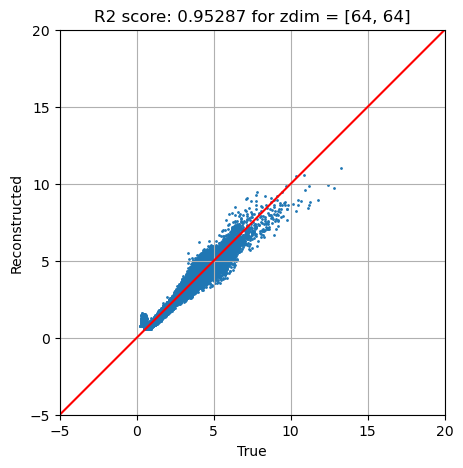

Text(0, 0.5, 'Score')

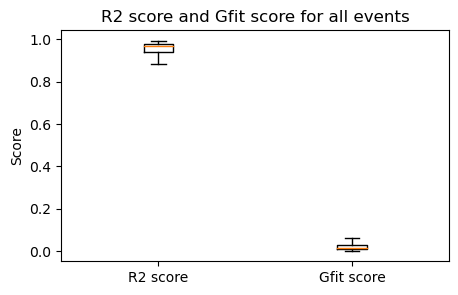

In [12]:
# # Flatten the tables along the n_gauge and n_time axes to get 2D arrays (neve, n_gauge * n_time)
Gfit_on = Gfit(test_dataset, recon_data)
flat_table1 = np.transpose(test_dataset)
flat_table2 = np.transpose(recon_data)

# Compute the R2 score for each event
r2_scores_on = r2_score(flat_table1, flat_table2, multioutput='raw_values')

# #count events with score above 0.7
print(np.sum(r2_scores_on > 0.7), 'events with R2 score above 0.7')
print(np.sum(Gfit_on < 0.1), 'events with Gfit score below 0.1')


# Plot results max height for all events
test_max = np.max(red_d_array,axis=(1))
recon_max = np.max(recon_data,axis=(1))

plt.figure(figsize=(5, 5))
plt.scatter(test_max, recon_max, s=1)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.title(f"R2 score: {r2_score(test_max, recon_max):.5f} for zdim = {channels_on}")
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-5, 20)
plt.ylim(-5, 20)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()

#plot r2 /gfit score as box plot
plt.figure(figsize=(5,3))
# Create the first box plot for R2 scores
positions = [1, 2]
plt.boxplot(r2_scores_on, showfliers=False, positions=[positions[0]])
# Create the second box plot for Gfit scores
plt.boxplot(Gfit_on, showfliers=False, positions=[positions[1]])
plt.gca().set_xticks(positions)
plt.gca().set_xticklabels(['R2 score', 'Gfit score'])

plt.title('R2 score and Gfit score for all events')
plt.ylabel('Score')



-0.01741082
0.07214684262256099


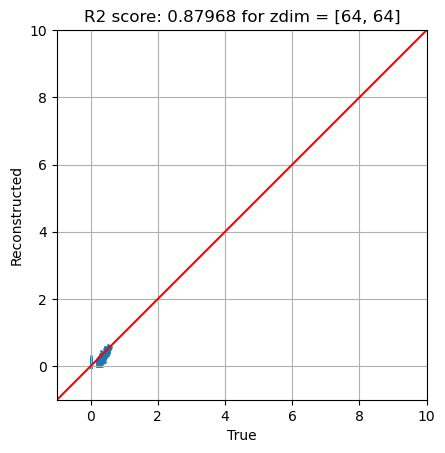

In [13]:
eve_no = 6843
print(min(recon_data[eve_no,:]))
print(Gfit_on[eve_no])

plt.scatter(test_dataset[eve_no,:], recon_data[eve_no,:], s=1)
plt.title(f"R2 score: {r2_score(test_dataset[eve_no,:], recon_data[eve_no,:]):.5f} for zdim = {channels_on}")
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()

# print(min(flat_table2[:,eve_no]))
# plt.scatter(flat_table1[:,eve_no], flat_table2[:,eve_no], s=1)
# plt.title(f"R2 score: {r2_score(flat_table1[:,eve_no], flat_table2[:,eve_no]):.5f} for zdim = {channels_on}")
# plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
# plt.gca().set_aspect('equal', adjustable='box')
# plt.xlim(-1, 10)
# plt.ylim(-1, 10)
# plt.grid()
# plt.xlabel('True')
# plt.ylabel('Reconstructed')
# plt.show()


DEFORMATION

In [ ]:
deform_model = torch.load(f"{MLDir}/model/{reg}/out/model_deform_ch_{channels_on}_minepoch_{train_size}.pt", map_location=torch.device('cpu'))# Test model for final evaluation
#read model from file for testing
model = deform_model
model.eval()
summary(model,(nflood_grids,))
criterion = nn.MSELoss()
print(red_dZ_array.shape)
test_dataset = torch.tensor(red_dZ_array, dtype=torch.float32).to('cpu')
print(test_dataset.shape)

with torch.no_grad():
    recon_data = model(test_dataset)
tloss = criterion(recon_data, test_dataset)
print(f"Test loss: {tloss :.5f}", end="\r")

recon_data = recon_data[:, :].cpu().detach().numpy()

# Flatten the tables along the n_gauge and n_time axes to get 2D arrays (neve, n_gauge * n_time)
flat_table1 = np.transpose(test_dataset)
flat_table2 = np.transpose(recon_data)

# Compute the R2 score for each event
r2_scores_on = r2_score(flat_table1, flat_table2, multioutput='raw_values')

#count events with score above 0.7
np.sum(r2_scores_on > 0.7)

# Plot results max height for all events
test_max = np.max(red_d_array,axis=(1))
recon_max = np.max(recon_data,axis=(1))

plt.figure(figsize=(5, 5))
plt.scatter(test_max, recon_max, s=1)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.title(f"R2 score: {r2_score(test_max, recon_max):.5f} for zdim = {channels_on}")
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-5, 20)
plt.ylim(-5, 20)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()

#plot r2 score as box plot
plt.figure(figsize=(10,5))
plt.boxplot(r2_scores_on,showfliers=False)
plt.title('R2 score for all events')
plt.ylabel('R2 score')
plt.show()

In [ ]:
eve_no = 9
print(min(recon_data[eve_no,:]))

plt.scatter(test_dataset[eve_no,:], recon_data[eve_no,:], s=1)
plt.title(f"R2 score: {r2_score(test_dataset[eve_no,:], recon_data[eve_no,:]):.5f} for zdim = {channels_on}")
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()

# print(min(flat_table2[:,eve_no]))
# plt.scatter(flat_table1[:,eve_no], flat_table2[:,eve_no], s=1)
# plt.title(f"R2 score: {r2_score(flat_table1[:,eve_no], flat_table2[:,eve_no]):.5f} for zdim = {channels_on}")
# plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
# plt.gca().set_aspect('equal', adjustable='box')
# plt.xlim(-1, 10)
# plt.ylim(-1, 10)
# plt.grid()
# plt.xlabel('True')
# plt.ylabel('Reconstructed')
# plt.show()


COUPLED MODEL AND FINAL OUTPUTS

In [10]:
couple_model = torch.load(f'{MLDir}/model/{reg}/out/model_couple_off{channels_off}_on{channels_on}_minepoch_{train_size}.pt', map_location=torch.device('cpu'))
#read model from file for testing
model = couple_model
model.eval()
summary(model,[(ts_dim,pts),(nflood_grids,1)])
criterion = nn.MSELoss()

print(t_array.shape)
test_dataset_in = torch.tensor(t_array[:10000], dtype=torch.float32).to('cpu')
print(test_dataset_in.shape)
print(red_d_array.shape)
test_dataset_out = torch.tensor(red_d_array[:10000], dtype=torch.float32).to('cpu')
print(test_dataset_out.shape)
print(red_dZ_array.shape)
test_dataset_deform = torch.tensor(red_dZ_array[:10000], dtype=torch.float32).to('cpu')
print(test_dataset_deform.shape)

#evaluate model in batch and combine reconstructions to get full dataset

with torch.no_grad():
    recon_data = model(test_dataset_in, test_dataset_deform)
tloss = criterion(recon_data, test_dataset_out)

print(f"Test loss: {tloss :.5f}")

recon_data1 = recon_data[:, :].cpu().detach().numpy()



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 480]           1,792
         LeakyReLU-2              [-1, 64, 480]               0
         AvgPool1d-3              [-1, 64, 240]               0
            Conv1d-4             [-1, 128, 240]          24,704
         LeakyReLU-5             [-1, 128, 240]               0
         AvgPool1d-6             [-1, 128, 120]               0
            Conv1d-7             [-1, 256, 120]          98,560
         LeakyReLU-8             [-1, 256, 120]               0
         AvgPool1d-9              [-1, 256, 60]               0
          Dropout-10              [-1, 256, 60]               0
          Flatten-11                [-1, 15360]               0
           Linear-12                   [-1, 64]         983,104
           Linear-13                   [-1, 64]           4,160
        LeakyReLU-14                   

torch.Size([10000, 416318])
(20430, 416318)
torch.Size([10000, 416318])
Test loss: 0.00240


In [11]:
print(t_array.shape)
test_dataset_in = torch.tensor(t_array[10000:], dtype=torch.float32).to('cpu')
print(test_dataset_in.shape)
print(red_d_array.shape)
test_dataset_out = torch.tensor(red_d_array[10000:], dtype=torch.float32).to('cpu')
print(test_dataset_out.shape)
print(red_dZ_array.shape)
test_dataset_deform = torch.tensor(red_dZ_array[10000:], dtype=torch.float32).to('cpu')
print(test_dataset_deform.shape)

#evaluate model in batch and combine reconstructions to get full dataset

with torch.no_grad():
    recon_data = model(test_dataset_in, test_dataset_deform)
tloss = criterion(recon_data, test_dataset_out)

print(f"Test loss: {tloss :.5f}")

recon_data2 = recon_data[:, :].cpu().detach().numpy()

(20430, 9, 480)
torch.Size([10430, 9, 480])
(20430, 416318)
torch.Size([10430, 416318])
(20430, 416318)
torch.Size([10430, 416318])
Test loss: 0.00231


In [12]:
#append reconstructions 1 and 2
recon_data = np.append(recon_data1,recon_data2,axis=0)
del recon_data1,recon_data2,test_dataset_in,test_dataset_deform,test_dataset_out

18992 events with R2 score above 0.7
18589 events with Gfit score below 0.1


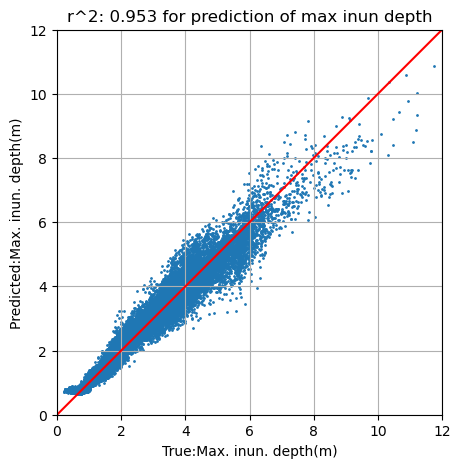

In [152]:
# # Flatten the tables along the n_gauge and n_time axes to get 2D arrays (neve, n_gauge * n_time)
# Gfit_out = Gfit(red_d_array, recon_data)
# flat_table1 = np.transpose(red_d_array)
# flat_table2 = np.transpose(recon_data)

# # Compute the R2 score for each event
# r2_scores_out = r2_score(flat_table1, flat_table2, multioutput='raw_values')

#count events with score above 0.7
print(np.sum(r2_scores_out > 0.7), 'events with R2 score above 0.7')
print(np.sum(Gfit_out < 0.1), 'events with Gfit score below 0.1')

# Plot results max height for all events
test_max = np.max(red_d_array,axis=(1))
recon_max = np.max(recon_data,axis=(1))

plt.figure(figsize=(5, 5))
plt.scatter(test_max, recon_max, s=1)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red',)
plt.title(f"r^2: {r2_score(test_max, recon_max):.3f} for prediction of max inun depth")
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 12)
plt.ylim(0, 12)
plt.grid()
plt.xlabel('True:Max. inun. depth(m)')
plt.ylabel('Predicted:Max. inun. depth(m)')
plt.show()

# #plot r2 /gfit score as box plot
# plt.figure(figsize=(5,3))
# # Create the first box plot for R2 scores
# positions = [1, 2]
# plt.boxplot(r2_scores_out, showfliers=False, positions=[positions[0]])
# # Create the second box plot for Gfit scores
# plt.boxplot(Gfit_out, showfliers=False, positions=[positions[1]])
# plt.gca().set_xticks(positions)
# plt.gca().set_xticklabels(['R2 score', 'Gfit score'])

# plt.title('R2 score and Gfit score for all events')
# plt.ylabel('Score')

In [19]:
#save reconstructions
np.save(f'{MLDir}/model/{reg}/out/recon_data_{reg}_{test_size}.npy',recon_data)
#save r2 and gfit scores
np.save(f'{MLDir}/model/{reg}/out/r2_scores_{reg}_{test_size}.npy',r2_scores_out)
np.save(f'{MLDir}/model/{reg}/out/Gfit_{reg}_{test_size}.npy',Gfit_out)

In [14]:
#read reconstructions and scores
recon_data = np.load(f'{MLDir}/model/{reg}/out/recon_data_{reg}_{test_size}.npy')
r2_scores_out = np.load(f'{MLDir}/model/{reg}/out/r2_scores_{reg}_{test_size}.npy')
Gfit_out = np.load(f'{MLDir}/model/{reg}/out/Gfit_{reg}_{test_size}.npy')

-0.019769179
0.995464584435043


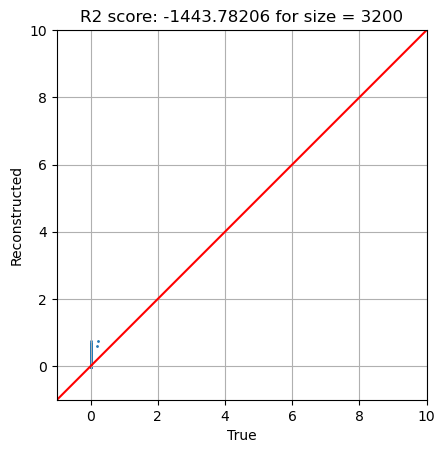

In [7]:
eve_no = 16918
print(min(recon_data[eve_no,:]))
print(Gfit_out[eve_no])

plt.scatter(red_d_array[eve_no,:], recon_data[eve_no,:], s=1)
plt.title(f"R2 score: {r2_score(red_d_array[eve_no,:], recon_data[eve_no,:]):.5f} for size = {train_size}")
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()

ANALYSIS AND PLOTTING

In [9]:
def calc_scores(true,pred,locindices,threshold=0.2):
    #only test where there is significant flooding
    true[true<threshold] = 0
    pred[pred<threshold] = 0
    mse_val = mean_squared_error(true,pred)
    r2_val = r2_score(true,pred)
    Gfit_val = Gfit_one(true,pred)
    pt_er = true[locindices] - pred[locindices]

    #calculate Aidan's no K and k small
    # ratio = true[true>=threshold]/pred[true>=threshold]    
    # logK = np.exp((np.log(ratio)).mean()) # Aidan's no K
    # logksmall = (np.mean((np.log(ratio))**2) - (logK**2))**0.5
    # Kcap = np.exp(logK)
    # Ksmall = np.exp(logksmall)

    return mse_val,r2_val,true[locindices],pred[locindices],pt_er,Gfit_val#,Kcap,Ksmall


In [212]:
if reg == 'CT':
  control_points =  [[37.5022,15.0960],
            [37.48876,15.08936],
            [37.47193,15.07816],
            [37.46851,15.08337], #airport 37.46851594, 15.08337672
            [37.46252,15.08587],
            [37.45312,15.07874],
            [37.42821,15.08506],
            [37.40958,15.08075],
            [37.38595,15.08539],
            [37.35084,15.08575],
            [37.33049,15.07029],
            [37.40675,15.05037] 
            ]
elif reg == 'SR':
  control_points = [[37.01,15.29],
      [37.06757,15.28709],
      [37.05266,15.26536],
      [37.03211,15.28632]]

def get_idx_from_latlon(locations,reg=reg,MLDir=MLDir,SimDir=SimDir,mask_size=mask_size):  
    #get first event to get lat lon
    firstevent = np.loadtxt(f'{MLDir}/data/events/sample_events53550.txt',dtype='str')[0]
    D_grids = xr.open_dataset(f'{SimDir}/{firstevent}/{reg}_flowdepth.nc')
    zero_mask = np.load(f'{MLDir}/data/processed/zero_mask_{reg}_{mask_size}.npy')
    non_zero_list = np.argwhere(~zero_mask).tolist()

    #iterate over list locations
    indices = []
    for loc in locations: 
        #get index of lat lon
        lat_idx = np.argmin(np.abs(D_grids.lat.values - loc[0]))
        lon_idx = np.argmin(np.abs(D_grids.lon.values - loc[1]))

        #get idx in non zero mask list from lat_idx and lon_idx
        idx = non_zero_list.index([lat_idx,lon_idx])
        indices.append(idx)

    # return lat_idx, lon_idx, idx
    print(indices)


    #calculate lat lon for all non zero list



    return indices

locindices = get_idx_from_latlon(control_points)
        #points to evaluate
# (2130, 653, 416589)
# (1980, 595, 406966)
# (1794, 496, 382850)
# (1691, 559, 366654)
# (1689, 564, 366384)
# (1585, 501, 348891)
# (1308, 557, 300485)
# (1101, 519, 261213)
# (839, 560, 196458)
# (450, 563, 127165)
# (224, 427, 61790)
# (1070, 252, 252416)

[414033, 404414, 380301, 374425, 363835, 346343, 297944, 258698, 193975, 124826, 59510, 249905]


In [213]:
#check performance per event
eve_perf = []
true_list = []
pred_list = []
er_list = []
threshold = 0.2

#mse_val,r2_val,true[locindices],pred[locindices],pt_er,Gfit_val #,KCap,Ksmall
for eve_no,eve in enumerate(event_list):
    if eve_no % 1000==0:
        print(eve_no)
    scores = calc_scores(red_d_array[eve_no,:], recon_data[eve_no,:],locindices,threshold)
    eve_perf.append([scores[0],scores[1],scores[5],#scores[6],scores[7], #mse,r2,Gfit,KCap,Ksmall
                     np.count_nonzero(red_d_array[eve_no,:]), #true count
                     np.count_nonzero(recon_data[eve_no,:])]), #pred count
    
    true_list.append(scores[2])
    pred_list.append(scores[3])
    er_list.append(scores[4])

#count of events less than 
eve_perf = np.array(eve_perf)
true_list = np.array(true_list)
pred_list = np.array(pred_list)
er_list = np.array(er_list)

#combine columns of true,pred,er into 12 column array
true_pred_er = np.column_stack((true_list,pred_list,er_list))

#append column with value from multiplie of column 0 and 4
eve_perf = np.column_stack((eve_perf,eve_perf[:,0]*eve_perf[:,4]))

#save to file
np.savetxt(f"./../../model/CT/out/er_coupled_finetuned_epoch_min.csv",true_pred_er,fmt='%.5f',delimiter=',')
np.savetxt(f"./../../model/CT/out/eve_perf_coupled_finetuned_epoch_min.csv",eve_perf,fmt='%.5f',delimiter=',')


0


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [18]:
#load from file
true_pred_er = np.loadtxt(f"./../../model/{reg}/out/er_coupled_finetuned_epoch_min.csv",delimiter=',')
eve_perf = np.loadtxt(f"./../../model/{reg}/out/eve_perf_coupled_finetuned_epoch_min.csv",delimiter=',')

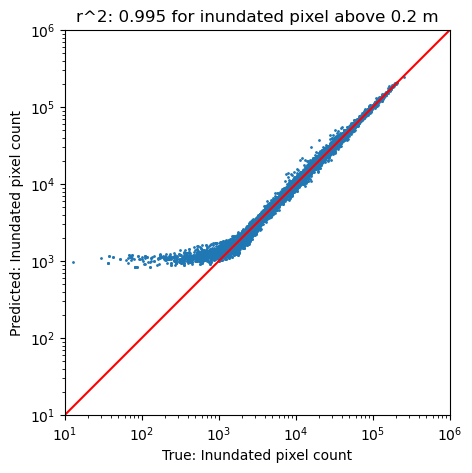

In [283]:
#plot scatter of flood count
plt.figure(figsize=(5, 5))
plt.scatter(eve_perf[:,3], eve_perf[:,4], s=1)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red',)
plt.title(f"r^2: {r2_score(eve_perf[:,3], eve_perf[:,4]):.3f} for inundated pixel above 0.2 m")
plt.gca().set_aspect('equal', adjustable='box')
#use log scale
plt.xscale('log')
plt.yscale('log')
plt.xlim(10, 1000000)
plt.ylim(10, 1000000)
# plt.grid()
plt.xlabel('True: Inundated pixel count')
plt.ylabel('Predicted: Inundated pixel count')
plt.show()

Control Location:1,No of flood events:929/20430
Control Location:2,No of flood events:2489/20430
Control Location:3,No of flood events:32/20430
Control Location:4,No of flood events:63/20430
Control Location:5,No of flood events:13777/20430
Control Location:6,No of flood events:56/20430
Control Location:7,No of flood events:1665/20430
Control Location:8,No of flood events:31/20430
Control Location:9,No of flood events:5151/20430
Control Location:10,No of flood events:284/20430
Control Location:11,No of flood events:2/20430
Control Location:12,No of flood events:0/20430


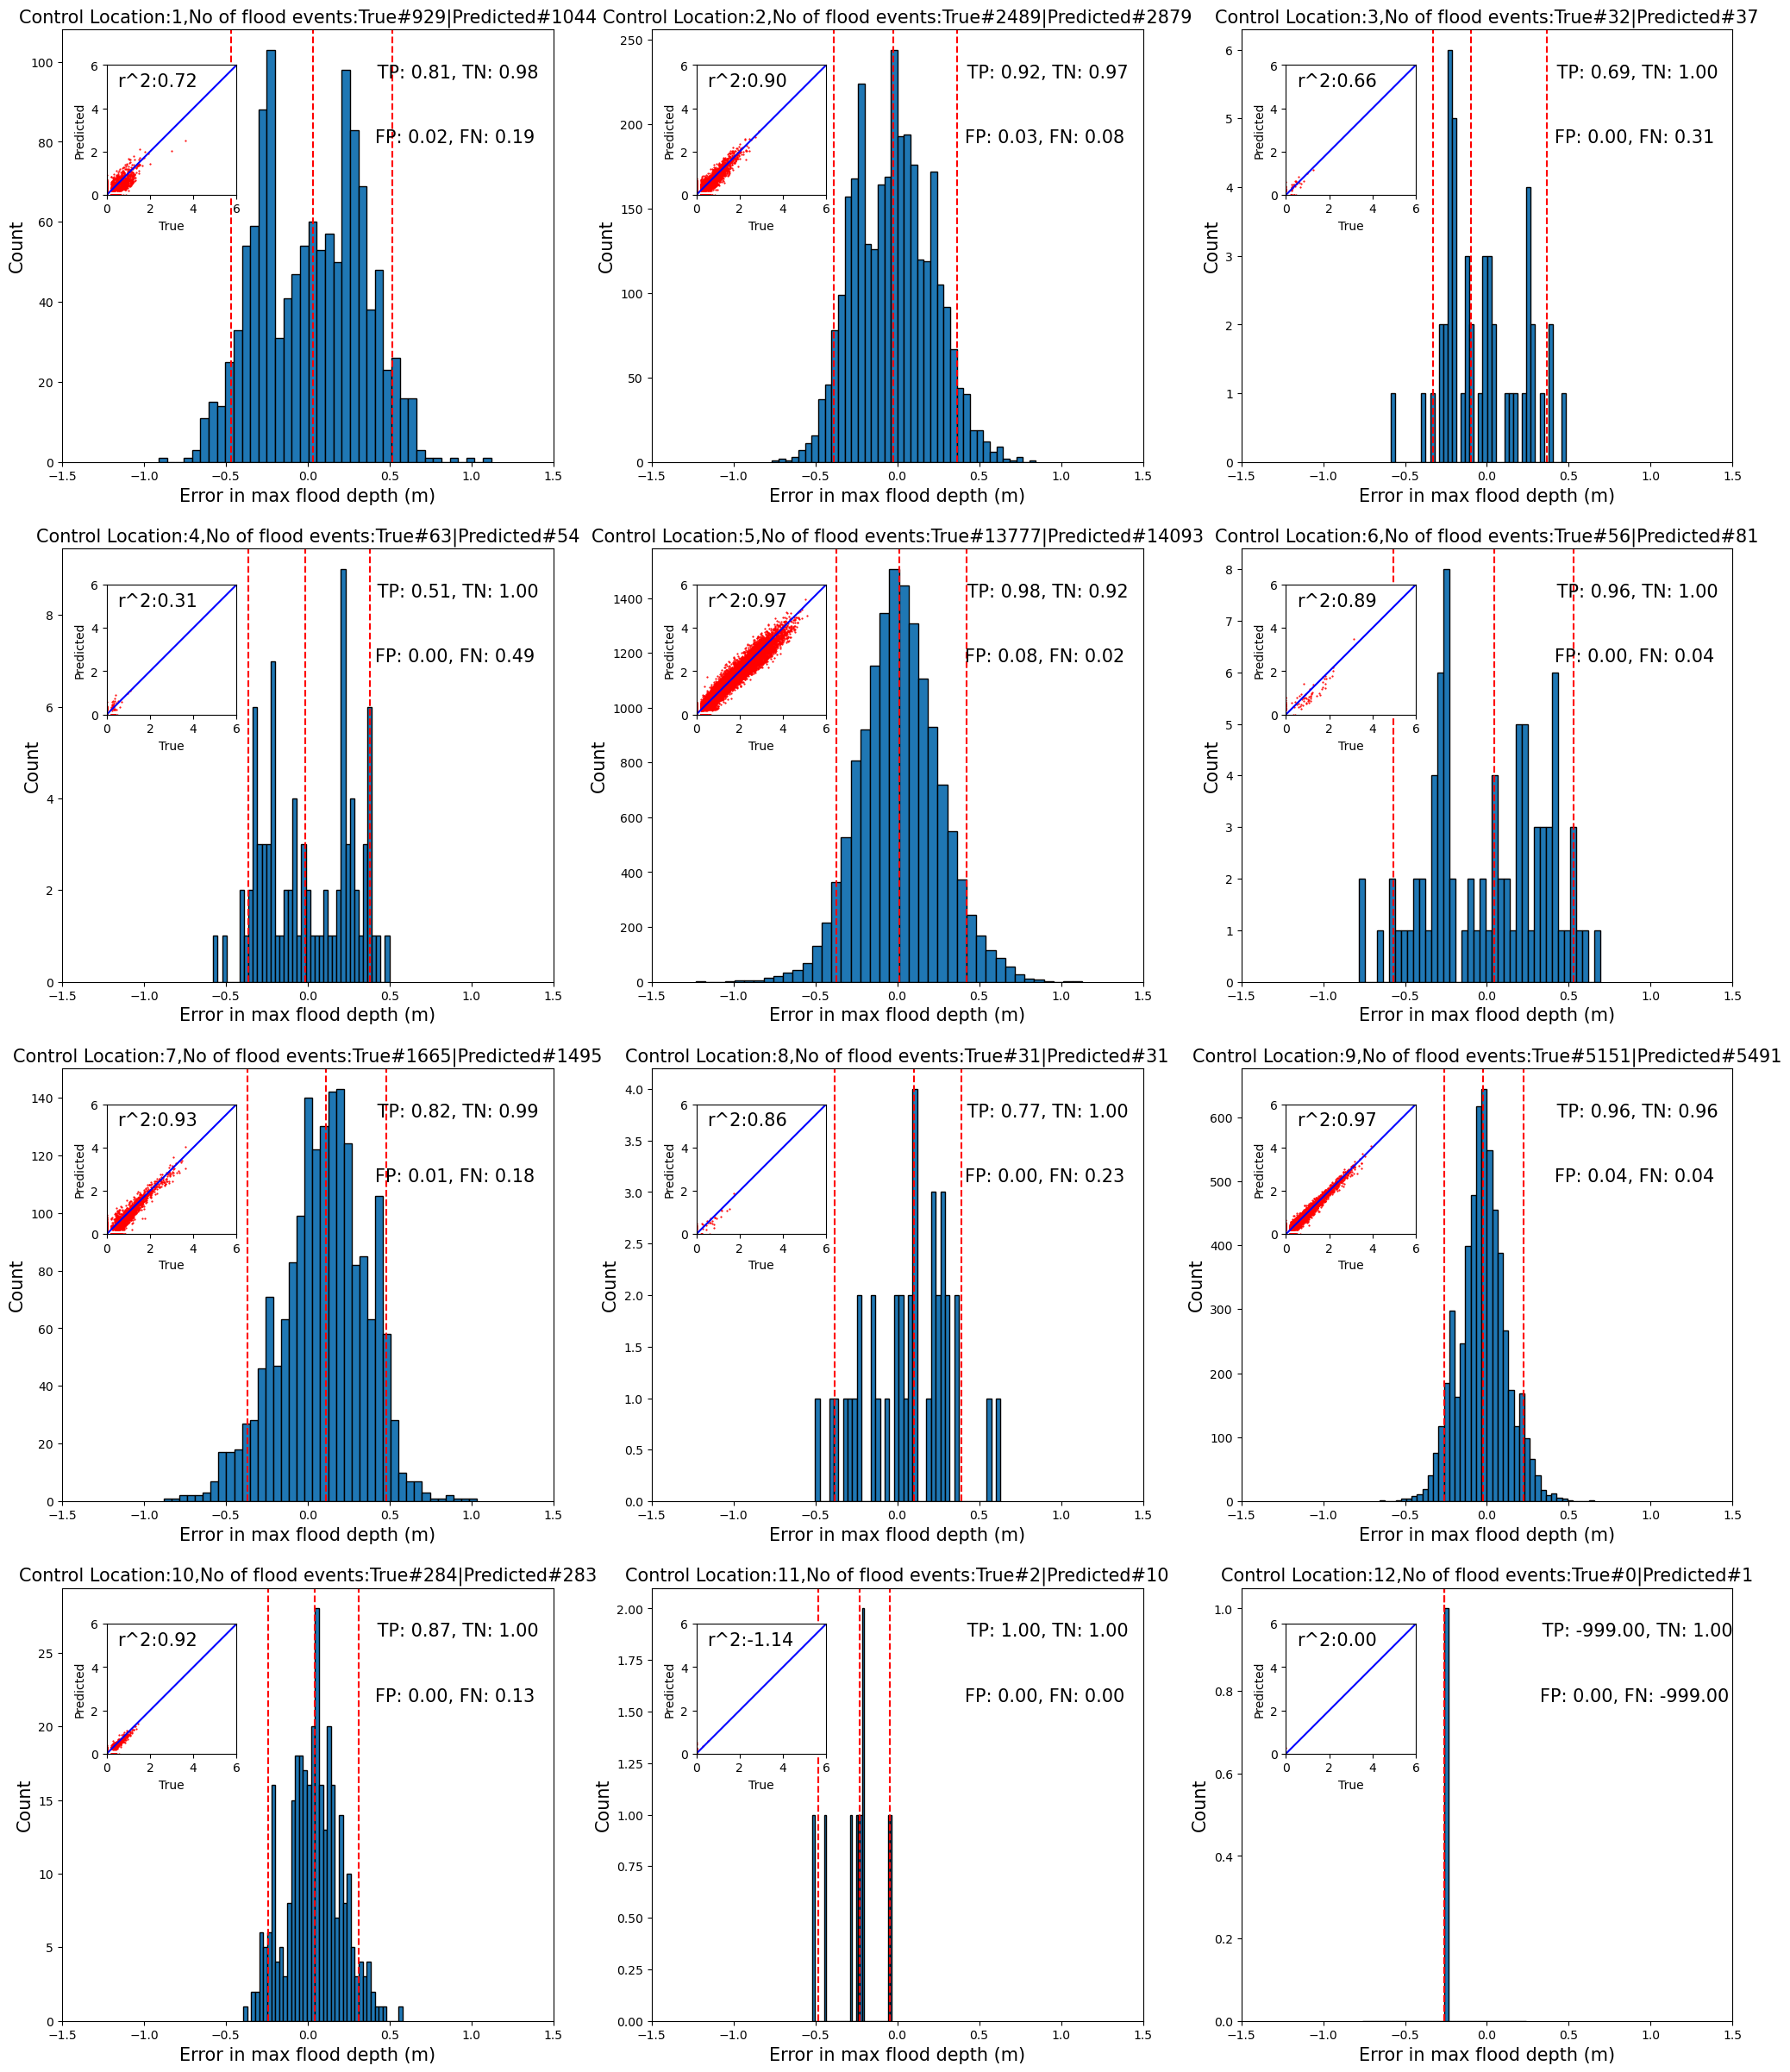

In [284]:

#plot the errors for the control locations as subplot from all events as histogram
plt.figure(figsize=(25, 30))
for i in range(len(locindices)):
    ax = plt.subplot(4, 3, i + 1)   
    # Plot the histogram of errors for the control locations
    plt.hist(er_list[er_list[:,i]!=0,i],bins=40,edgecolor='black',)
    quantiles = np.percentile(er_list[er_list[:,i]!=0,i], [5, 50, 95])
    # Plot quantile lines
    for q in quantiles:
        ax.axvline(q, color='red', linestyle='--', label=f'Q{int(q)}')
    ax.set_xlim(-1.5, 1.5)

    #calculate hit and mis for each location based on depth of true and prediction
    #events crossing the threshold say 0.2 are considered flooded
    neve = np.count_nonzero(true_pred_er[:,i]>threshold)
    neve_recon = np.count_nonzero(true_pred_er[:,i+len(locindices)]>threshold)
    print(f"Control Location:{i+1},No of flood events:{neve}/{len(true_pred_er[:,i])}")
    if neve == 0:
        TP = -999
        FN = -999
    else:
    #true positive: true>0.2 and pred>0.2
        TP = np.count_nonzero((true_pred_er[:,i]>threshold) & (true_pred_er[:,i+len(locindices)]>threshold))/(neve)
        FN = np.count_nonzero((true_pred_er[:,i]>threshold) & (true_pred_er[:,i+len(locindices)]<=threshold))/(neve)
    TN = np.count_nonzero((true_pred_er[:,i]<=threshold) & (true_pred_er[:,i+len(locindices)]<=threshold))/(len(true_pred_er[:,i])-neve)
    FP = np.count_nonzero((true_pred_er[:,i]<=threshold) & (true_pred_er[:,i+len(locindices)]>threshold))/(len(true_pred_er[:,i])-neve)
    plt.title(f"Control Location:{i+1},No of flood events:True#{neve}|Predicted#{neve_recon}",fontsize=15)
    plt.text(0.8, 0.9, f" TP: {TP:.2f}, TN: {TN:.2f}", horizontalalignment='center',verticalalignment='center', transform=plt.gca().transAxes,fontsize=15)
    plt.text(0.8, 0.75, f"FP: {FP:.2f}, FN: {FN:.2f}", horizontalalignment='center',verticalalignment='center', transform=plt.gca().transAxes,fontsize=15)
    plt.xlabel('Error in max flood depth (m)',fontsize=15)
    plt.ylabel('Count',fontsize=15)

    # Create a new inset axis for the scatter plot
    axins = inset_axes(ax, width="30%", height="30%", loc='upper left', borderpad=3)
    
    # Scatter plot of values (replace with your data)
    axins.plot([0, 1], [0, 1], transform=axins.transAxes, color='blue',)
    axins.scatter(true_pred_er[:,i], true_pred_er[:,i+len(locindices)], marker='o', color='red', label='Max Inun Depth',s=0.33)  # Customize marker and color as needed
    axins.text(0.5,5,f'r^2:{r2_score(true_pred_er[:,i], true_pred_er[:,i+len(locindices)]):.2f}',fontsize=15)
    axins.set_xlim(0, 6)  # Adjust x-axis limits for the scatter plot
    axins.set_ylim(0, 6)  # Adjust y-axis limits for the scatter plot
    axins.set_xlabel('True')
    axins.set_ylabel('Predicted')
    axins.set_aspect('equal', adjustable='box')
    
    
    # Add a legend to the inset axis

    # plt.grid()
# plt.suptitle(f"Error distribution for the control locations for {len(eve_perf)} test events")

/tmp/ipykernel_3671225/2772291736.py:5: RuntimeWarning: divide by zero encountered in divide
  reler_list = np.where(true_list != 0, pred_list / true_list, 0.0)
/tmp/ipykernel_3671225/2772291736.py:5: RuntimeWarning: invalid value encountered in divide
  reler_list = np.where(true_list != 0, pred_list / true_list, 0.0)


Control Location:1,No of flood events:929/20430
Control Location:2,No of flood events:2489/20430
Control Location:3,No of flood events:32/20430
Control Location:4,No of flood events:4185/20430
Control Location:5,No of flood events:13777/20430
Control Location:6,No of flood events:56/20430
Control Location:7,No of flood events:1665/20430
Control Location:8,No of flood events:31/20430
Control Location:9,No of flood events:5151/20430
Control Location:10,No of flood events:284/20430
Control Location:11,No of flood events:2/20430
Control Location:12,No of flood events:0/20430


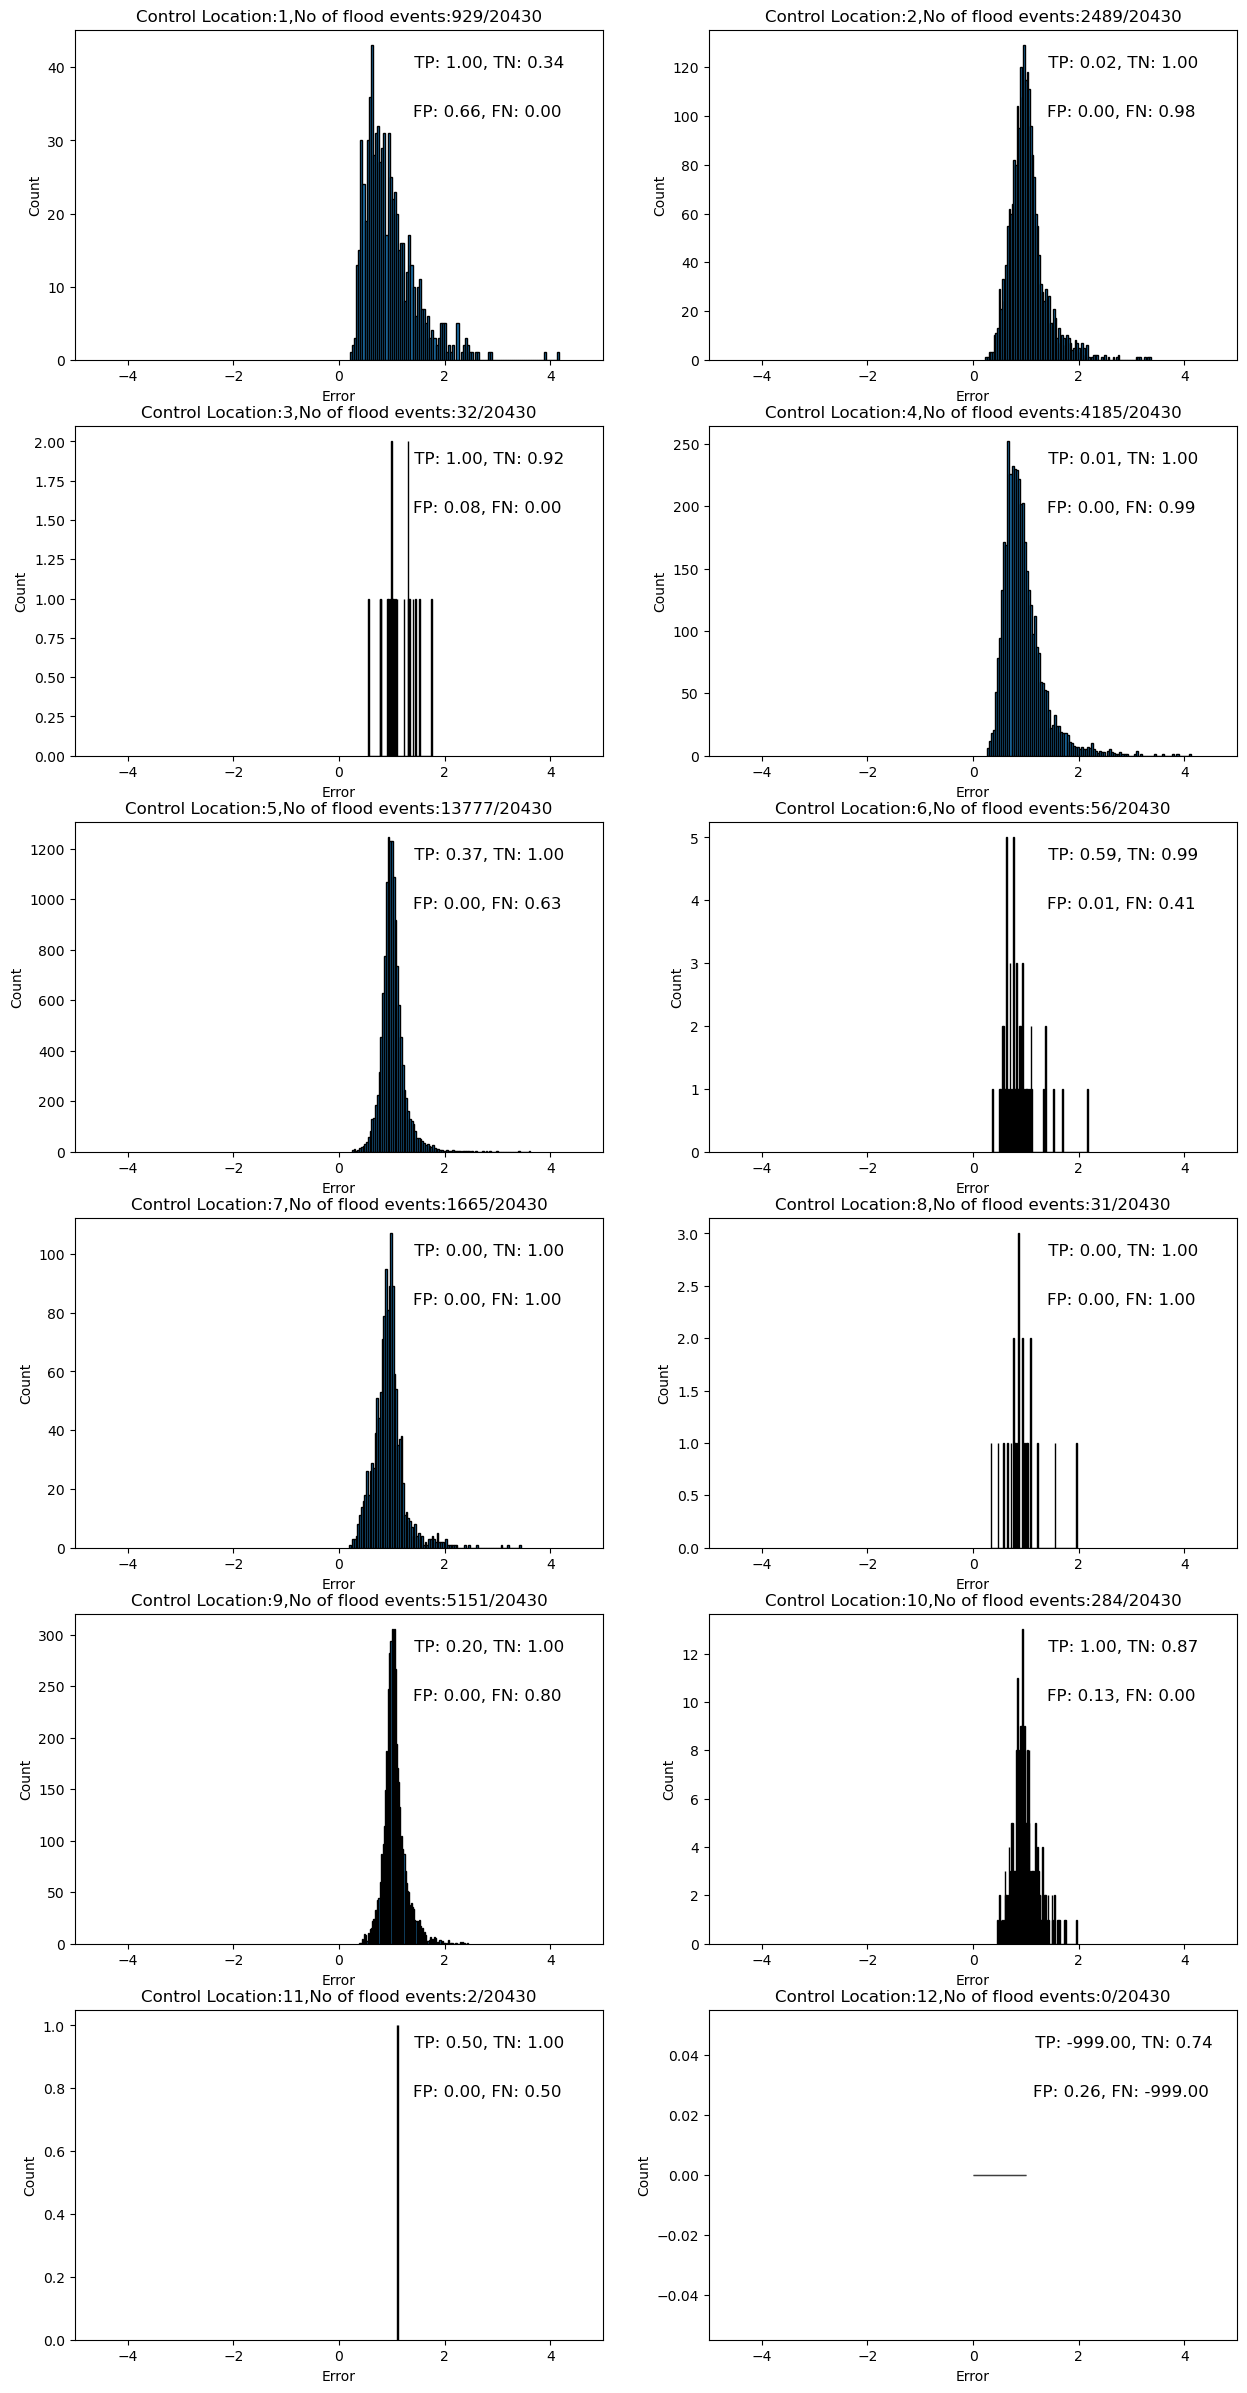

In [18]:
#set true value less than threshold to zero
true_list[true_list<threshold] = 0

#calculate rel error for each row/column variable where er is not zero
reler_list = np.where(true_list != 0, pred_list / true_list, 0.0)

#plot the errors for the control locations as subplot from all events as histogram
plt.figure(figsize=(15, 30))
for i in range(12):
    plt.subplot(6,2,i+1)
    plt.hist(reler_list[reler_list[:,i]!=0,i],bins=100,edgecolor='black')
    #set x axis to be the same for all subplots
    plt.xlim(-5,5)
    #calculate hit and mis for each location based on depth of true and prediction
    #events crossing the threshold of 0.2 are considered flooded
    neve = np.count_nonzero(true_pred_er[:,i]>threshold)
    print(f"Control Location:{i+1},No of flood events:{neve}/{len(true_pred_er[:,i])}")
    if neve == 0:
        TP = -999
        FN = -999
    else:
    #true positive: true>0.2 and pred>0.2
        TP = np.count_nonzero((true_pred_er[:,i]>threshold) & (true_pred_er[:,i+4]>threshold))/(neve)
        FN = np.count_nonzero((true_pred_er[:,i]>threshold) & (true_pred_er[:,i+4]<=threshold))/(neve)
    TN = np.count_nonzero((true_pred_er[:,i]<=threshold) & (true_pred_er[:,i+4]<=threshold))/(len(true_pred_er[:,i])-neve)
    FP = np.count_nonzero((true_pred_er[:,i]<=threshold) & (true_pred_er[:,i+4]>threshold))/(len(true_pred_er[:,i])-neve)
    plt.title(f"Control Location:{i+1},No of flood events:{neve}/{len(true_pred_er[:,i])}")
    plt.text(0.78, 0.9, f" TP: {TP:.2f}, TN: {TN:.2f}", horizontalalignment='center',verticalalignment='center', transform=plt.gca().transAxes,fontsize=12)
    plt.text(0.78, 0.75, f"FP: {FP:.2f}, FN: {FN:.2f}", horizontalalignment='center',verticalalignment='center', transform=plt.gca().transAxes,fontsize=12)
    plt.xlabel('Error')
    plt.ylabel('Count')
    # plt.grid()
# plt.suptitle(f"Error distribution for 4 control locations for {len(eve_perf)} test events")

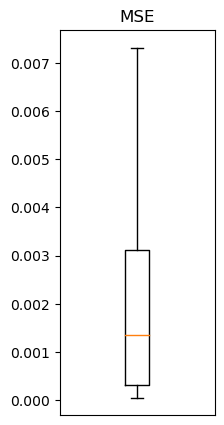

([], [])

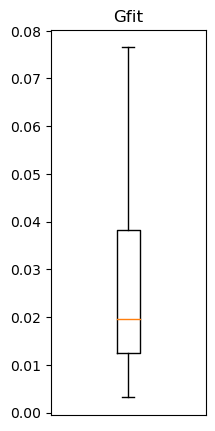

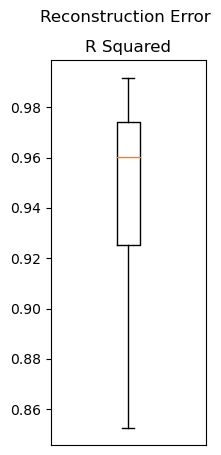

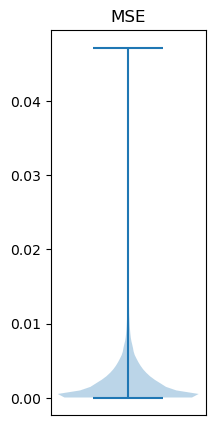

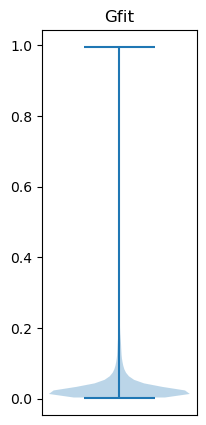

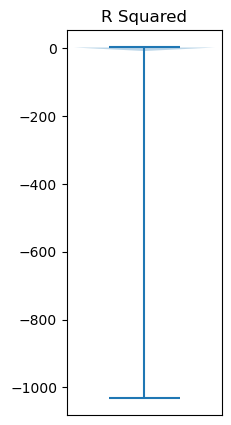

In [27]:
#plot the mse and r2 for all the events as box plot
plt.figure(figsize=(2, 5))
plt.boxplot(eve_perf[:,0],showfliers=False)
plt.title('MSE')
plt.xticks([])
plt.show()

#plot the mse and r2 for all the events as box plot
plt.figure(figsize=(2, 5))
plt.boxplot(eve_perf[:,2],showfliers=False)
plt.title('Gfit')
plt.xticks([])


plt.figure(figsize=(2, 5))
plt.boxplot(eve_perf[:,1],showfliers=False)
plt.title('R Squared')
plt.xticks([])

plt.suptitle(f"Reconstruction Error") # {len(eve_perf)} test events


# #make violin plot of the errors
# plt.figure(figsize=(15, 10))
# for i in range(4):
#     plt.subplot(2,2,i+1)
#     plt.violinplot(er_list[er_list[:,i]!=0,i],showmeans=True)
#     plt.xlim(-1,1)
#     plt.title(f"Control Location:{i+1}")
#     plt.xlabel('Error')
#     plt.ylabel('Count')
#     # plt.grid()


#make violin plot of the errors MSE and R2
plt.figure(figsize=(2, 5))
plt.violinplot(eve_perf[:,0],showmeans=False)
plt.title('MSE')
plt.xticks([])

plt.figure(figsize=(2, 5))
plt.violinplot(eve_perf[:,2],showmeans=False)
plt.title('Gfit')
plt.xticks([])

plt.figure(figsize=(2, 5))
plt.violinplot(eve_perf[:,1],showmeans=False)
plt.title('R Squared')
plt.xticks([])
# plt.suptitle(f"Reconstruction Error") # {len(eve_perf)} test events



In [ ]:
for param in model.offshore_encoder.parameters():
    print(param.shape, param.requires_grad)

torch.Size([64, 9, 3]) False
torch.Size([64]) False
torch.Size([128, 64, 3]) False
torch.Size([128]) False
torch.Size([256, 128, 3]) False
torch.Size([256]) False
torch.Size([64, 15360]) True
torch.Size([64]) True


In [ ]:
for param in model.onshore_decoder.parameters():
    print(param.shape, param.requires_grad)

torch.Size([64, 64]) True
torch.Size([64]) True
torch.Size([416330, 64]) False
torch.Size([416330]) False


In [ ]:
for param in model.connect.parameters():
    print(param.shape, param.requires_grad)

torch.Size([64, 64]) True
torch.Size([64]) True
torch.Size([64, 64]) True
torch.Size([64]) True


In [ ]:
for param in model.parameters():
    print(param.shape, param.requires_grad)

torch.Size([64, 9, 3]) False
torch.Size([64]) False
torch.Size([128, 64, 3]) False
torch.Size([128]) False
torch.Size([256, 128, 3]) False
torch.Size([256]) False
torch.Size([64, 15360]) True
torch.Size([64]) True
torch.Size([64, 416330]) False
torch.Size([64]) False
torch.Size([64, 64]) False
torch.Size([64]) False
torch.Size([64, 64]) True
torch.Size([64]) True
torch.Size([64, 64]) True
torch.Size([64]) True
torch.Size([64, 64]) True
torch.Size([64]) True
torch.Size([416330, 64]) False
torch.Size([416330]) False


<Figure size 1000x600 with 0 Axes>

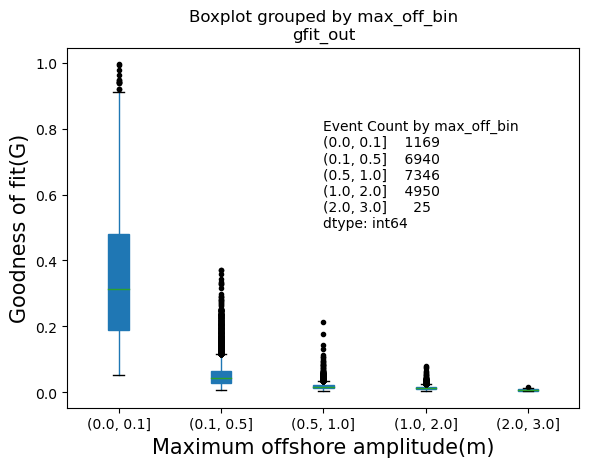

In [38]:
#append r2_scores_out to true_pred_er columns 
table = pd.DataFrame(true_pred_er)
table['r2_scores_out'] = r2_scores_out
table['id'] = event_list
table['gfit_out'] = Gfit_out
table['mse'] = eve_perf[:,0]
table['true'] = eve_perf[:,3]
table['pred'] = eve_perf[:,4]

#read sampling file and append to table based on event_id
sampling_file = pd.read_csv('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/info/sampling_input_CT_41.csv')
table = table.merge(sampling_file, on='id', how='left')
#save to output file
table.to_csv('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/CT/out/PStrue_pred_er_r2scores.csv', index=False)

# Set the bin edges for 'max_off' values
bin_edges = [0, 0.1, 0.5, 1, 2, 3]  # Define your custom bin edges here

# Create a box plot of 'gfit_out' binned by 'max_off' using custom bin edges
plt.figure(figsize=(10, 6))
table['max_off_bin'] = pd.cut(table['max_off'], bin_edges)
table.boxplot(column='gfit_out', by='max_off_bin', vert=True, showfliers=True,widths=0.2,sym='k.',patch_artist=True)
bin_counts = table.groupby('max_off_bin').size()
# Set labels and titles
plt.ylabel('Goodness of fit(G)',fontsize=15)
plt.xlabel('Maximum offshore amplitude(m)',fontsize=15)
plt.text(3, 0.5, f'Event Count by {bin_counts}')
#turn off grid
plt.grid(False)
# Show the plot
plt.show()


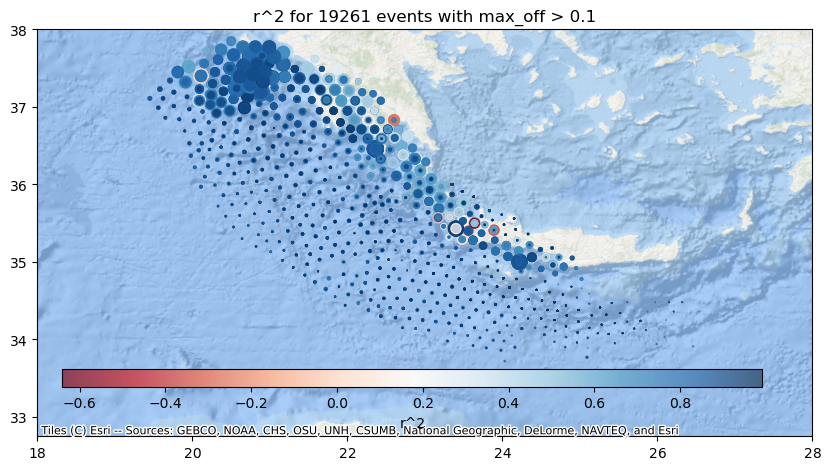

In [31]:
#plot events with lat lon and r2score as color
#load file
sample_test = pd.read_csv('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/CT/out/PStrue_pred_er_r2scores.csv')

sample_test = sample_test[sample_test['max_off'] > 0.1]

#set r2score to -1 if it is negative
# sample_test.loc[sample_test['r2_scores_out'] < 0, 'r2_scores_out'] = -1

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 7))

# Set the title
ax.set_title('r^2 for ' + str(len(sample_test)) + ' events with max_off > 0.1')

# Create a scatter plot
scatter = ax.scatter(sample_test['lon'], sample_test['lat'], c=sample_test['r2_scores_out'],
                      cmap='RdBu', s=sample_test['mean_prob'] * 5000000, alpha=0.75)

# Set the plot limits
plt.xlim(18, 28)
plt.ylim(32.75, 38)

# Add a basemap
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.OceanBasemap)

# Position the colorbar inside the map plot
cax = fig.add_axes([0.15, 0.275, 0.7, 0.025])  # Adjust the position as needed
cbar = plt.colorbar(scatter, cax=cax, orientation='horizontal', label='r^2')

# Show the plot
plt.show()


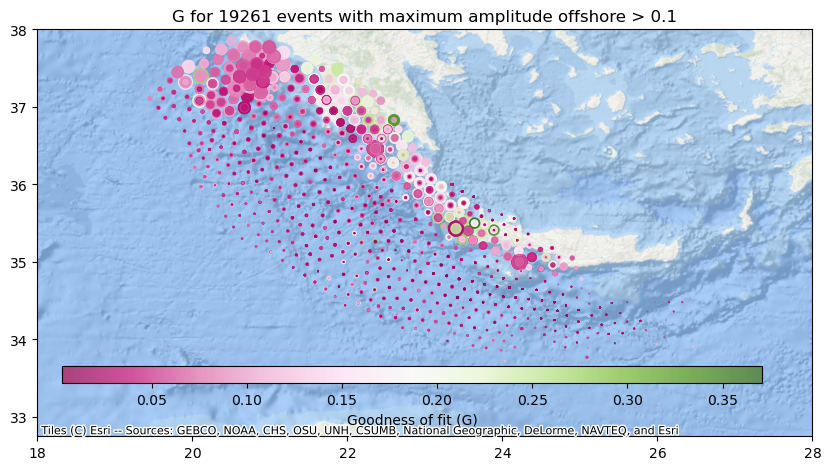

In [36]:
import matplotlib.pyplot as plt
import contextily as cx

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 7))

# Set the title
ax.set_title('G for ' + str(len(sample_test)) + ' events with maximum amplitude offshore > 0.1')

# Create a scatter plot
scatter = ax.scatter(sample_test['lon'], sample_test['lat'], c=sample_test['gfit_out'],
                      cmap='PiYG', s=sample_test['mean_prob'] * 5000000, alpha=0.75)

# Set the plot limits
plt.xlim(18, 28)
plt.ylim(32.75, 38)

# Add a basemap
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.OceanBasemap)

# Position the colorbar inside the map plot
cax = fig.add_axes([0.15, 0.28, 0.7, 0.025])  # Adjust the position as needed
cbar = plt.colorbar(scatter, cax=cax, orientation='horizontal', label='Goodness of fit (G)')

# Show the plot
plt.show()


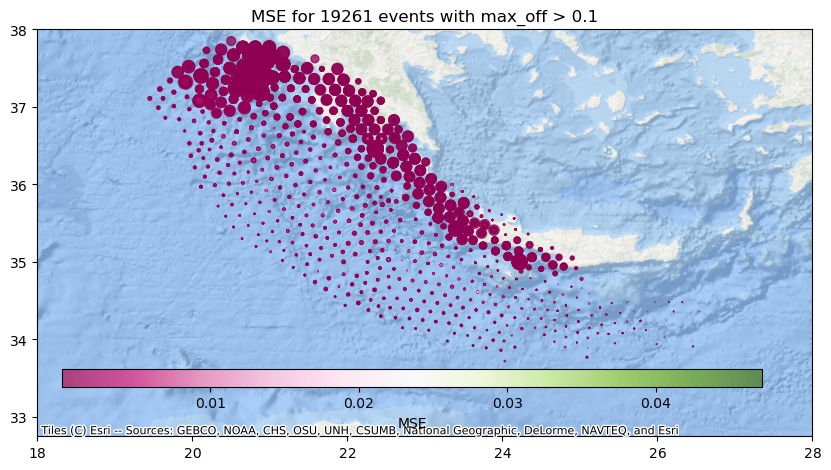

In [14]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 7))

# Set the title
ax.set_title('MSE for ' + str(len(sample_test)) + ' events with max_off > 0.1')

# Create a scatter plot
scatter = ax.scatter(sample_test['lon'], sample_test['lat'], c=sample_test['mse'],
                      cmap='PiYG', s=sample_test['mean_prob'] * 5000000, alpha=0.75)

# Set the plot limits
plt.xlim(18, 28)
plt.ylim(32.75, 38)

# Add a basemap
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.OceanBasemap)

# Position the colorbar inside the map plot
cax = fig.add_axes([0.15, 0.275, 0.7, 0.025])  # Adjust the position as needed
cbar = plt.colorbar(scatter, cax=cax, orientation='horizontal', label='MSE')

# Show the plot
plt.show()

In [12]:
firstevent = np.loadtxt(f'{MLDir}/data/events/sample_events53550.txt',dtype='str')[0]
D_grids = xr.open_dataset(f'{SimDir}/{firstevent}/{reg}_flowdepth.nc')
zero_mask = np.load(f'{MLDir}/data/processed/zero_mask_{reg}_{mask_size}.npy')
non_zero_list = np.argwhere(~zero_mask).tolist()

# #calculate lat lon for all non zero list
# lat_list = []
# lon_list = []
# for idx in non_zero_list:
#     lat_list.append(D_grids.lat.values[idx[0]])
#     lon_list.append(D_grids.lon.values[idx[1]])

# #combine lat,lon,idx into 3 column array
# lat_lon_idx = np.column_stack((non_zero_list,lat_list,lon_list))

# #save to processed folder
# np.save(f'{MLDir}/data/processed/lat_lon_idx_{reg}_{mask_size}.npy',lat_lon_idx)

# #as txt
# np.savetxt(f'{MLDir}/data/processed/lat_lon_idx_{reg}_{mask_size}.txt',lat_lon_idx,fmt='%.5f',delimiter=',')

    

In [4]:
#load exposure values of pop and buildings at each location represented by lat lon of area 10m x 10m
exposure = pd.read_csv('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/resources/gis/exposure/ExposureTable.csv')
exposure['GHSPop1'] = exposure['GHSPop1']/100

total GHSL pop in flood envelop: 4262.628917052963


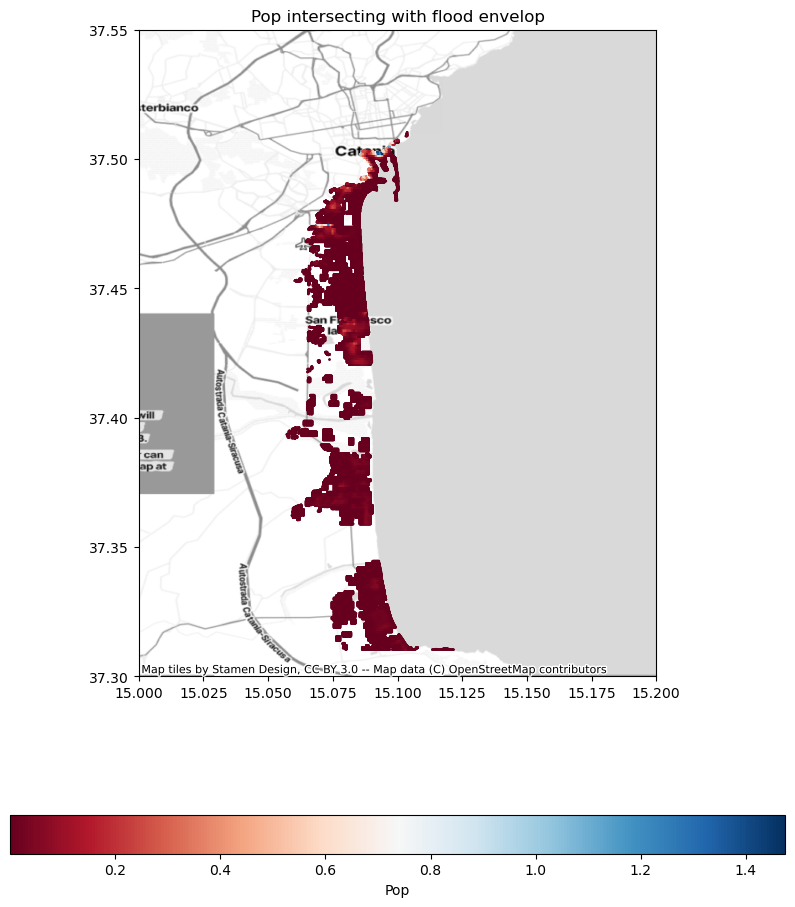

In [17]:
print('total GHSL pop in flood envelop:',np.sum(exposure['GHSPop1']))

#plot pop and build exposure using lat lon and exposure values
fig, ax = plt.subplots(figsize=(10,12))
ax.title.set_text('Pop intersecting with flood envelop')
ax = plt.scatter(exposure['field_4'], exposure['field_3'],c=exposure['GHSPop1'],
                  cmap='RdBu',s=0.51)
plt.colorbar(ax, label='Pop', orientation='horizontal')
plt.xlim(15, 15.2)
plt.ylim(37.3, 37.55)
ax = plt.gca()
cx.add_basemap(ax,crs='EPSG:4326', source=cx.providers.Stamen.TonerLite)
plt.show()

total unbuilt area in flood envelop: 30886500
total residential area in flood envelop: 9703900
total non residential area in flood envelop: 1041400


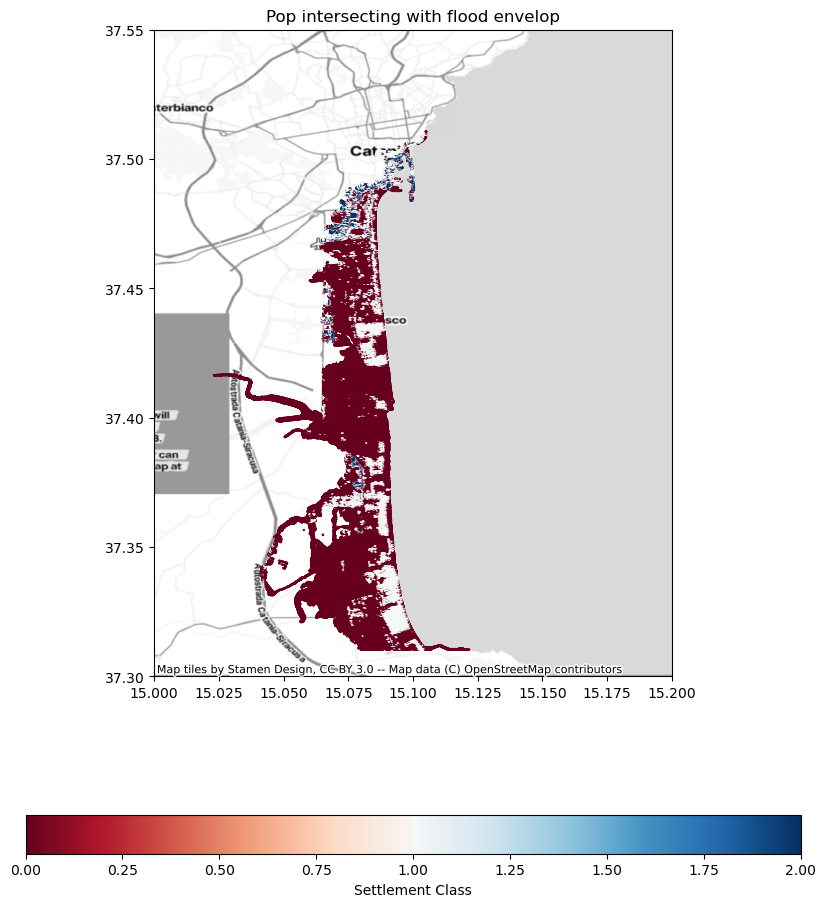

In [18]:
print('total unbuilt area in flood envelop:',np.sum(exposure['Built1']==0)*100)
print('total residential area in flood envelop:',np.sum(exposure['Built1']==1)*100)
print('total non residential area in flood envelop:',np.sum(exposure['Built1']==2)*100)

#plot pop and build exposure using lat lon and exposure values
fig, ax = plt.subplots(figsize=(10,12))
ax.title.set_text('Pop intersecting with flood envelop')
ax = plt.scatter(exposure['field_4'], exposure['field_3'],c=exposure['Built1'],
                  cmap='RdBu',s=0.51)
plt.colorbar(ax, label='Settlement Class', orientation='horizontal')
plt.xlim(15, 15.2)
plt.ylim(37.3, 37.55)
ax = plt.gca()
cx.add_basemap(ax,crs='EPSG:4326', source=cx.providers.Stamen.TonerLite)
plt.show()

In [3]:
#calculate loss estimate per flood event using pop and build exposure using 3 depth bins: 0.1,1,3
def cal_impact(eve,exptype,var): #var: pop or build

    exp = exposure[exptype]
    if var == 'true':
        val= red_d_array[eve,:] 
    elif var == 'pred':
        val = recon_data[eve,:]
    
    print('exp type and total:',exptype,np.sum(exp))
    print('loss for :',var)
    # print(exp.shape)
    # print(val.shape)

    #set true and pred value less than threshold to zero
    val[val<threshold] = 0
    loss_ratio = [0,0.3,0.5,1]
    depth_bins = [0.2,1,3]

    #calculate loss estimate per flood event using pop and build exposure using 3 depth bins: threshold ie 0.1,1,3
    loss = []
    safe = []
    low = []
    medium = []
    high = []

    if  exptype == 'GHSPop1':
        safe = np.sum(exp[(val<=depth_bins[0])])
        low = np.sum(exp[(val>depth_bins[0]) & (val<=depth_bins[1])])
        medium = np.sum(exp[(val>depth_bins[1]) & (val<=depth_bins[2])])
        high = np.sum(exp[(val>depth_bins[2])])
        
    elif exptype == 'Built1':
        safe = np.sum(exp[(val<=depth_bins[0])])
        low = np.sum(exp[(val>depth_bins[0]) & (val<=depth_bins[1])])*loss_ratio[1]
        medium = np.sum(exp[(val>depth_bins[1]) & (val<=depth_bins[2])])*loss_ratio[2]
        high = np.sum(exp[(val>depth_bins[2])])*loss_ratio[3]
    total = low + medium + high
    
    return safe,low,medium,high,total


0.0
0.00746534102627372


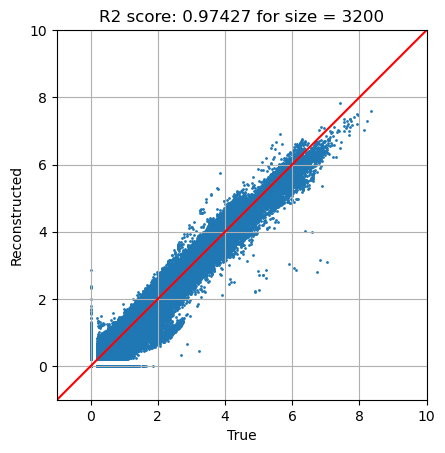

-----------------
exp type and total: GHSPop1 4262.628917052963
loss for : true
(2108.3300283450353, 756.5697466577961, 1278.7771701055626, 118.95197194456797, 2154.298888707927)
exp type and total: GHSPop1 4262.628917052963
loss for : pred
(2064.71809693687, 783.3428564020815, 1288.0816938616829, 126.48626985232826, 2197.9108201160925)
-----------------
exp type and total: Built1 117867
loss for : true
(38639, 8407.5, 22122.0, 6959, 37488.5)
exp type and total: Built1 117867
loss for : pred
(37430, 8637.0, 22215.0, 7217, 38069.0)


In [24]:
eve_no = 1795
print(min(recon_data[eve_no,:]))
print(Gfit_out[eve_no])

plt.scatter(red_d_array[eve_no,:], recon_data[eve_no,:], s=1)
plt.title(f"R2 score: {r2_score(red_d_array[eve_no,:], recon_data[eve_no,:]):.5f} for size = {train_size}")
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()
print('-----------------')
print(cal_impact(eve_no,'GHSPop1','true'))
print(cal_impact(eve_no,'GHSPop1','pred'))
print('-----------------')
print(cal_impact(eve_no,'Built1','true'))
print(cal_impact(eve_no,'Built1','pred'))

plot event in folium map

In [25]:
#find event id for this mse
filter = sample_test[sample_test['mse']>np.quantile(sample_test['mse'],0.999)]


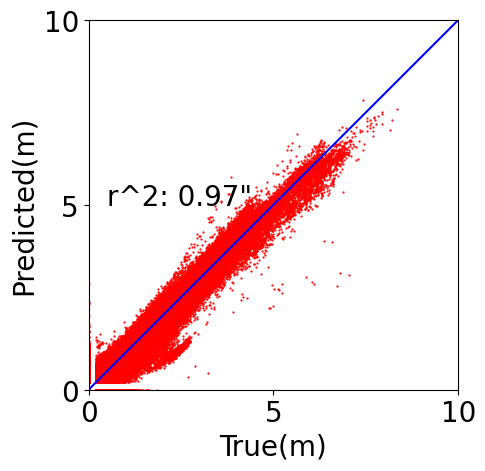

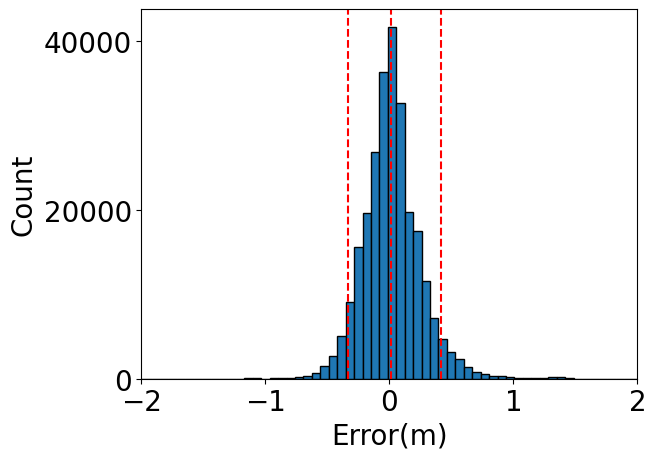

In [29]:
import base64

eve_no = 1795 
eve = event_list[eve_no]

#grid map
error2fill = np.zeros(D_grids.z.shape)
depth2fill = np.zeros(D_grids.z.shape)

zero_mask = np.load('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/processed/zero_mask_CT_3200.npy')
error2fill[~zero_mask] = red_d_array[eve_no, :] - recon_data[eve_no, :]
depth2fill[~zero_mask] = recon_data[eve_no,:]

true = red_d_array[eve_no,:]
pred = recon_data[eve_no,:]
true[true<threshold] = 0
pred[pred<threshold] = 0
error = true - pred

#plot scatter
plt.scatter(true, pred, marker='o', color='red', label='Max Inun Depth',s=0.33)
plt.text(0.5,5,f'r^2: {eve_perf[eve_no,1]:.2f}"',fontsize=20)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='blue')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0,10)
plt.ylim(0,10)
#show x and y value only at interval of 5
plt.xticks(np.arange(0, 11, 5),fontsize=20)
plt.yticks(np.arange(0, 11, 5),fontsize=20)
plt.xlabel('True(m)',fontsize=20)
plt.ylabel('Predicted(m)',fontsize=20)
plt.show()

#plot error as histogram
plt.hist(error[error!=0],bins=100,edgecolor='black',)
quantiles = np.percentile(error[error!=0], [5, 50, 95])
# Plot quantile lines
for q in quantiles:
        plt.axvline(q, color='red', linestyle='--', label=f'Q{int(q)}')
plt.xlim(-2,2)
#show x value at interval of 1
plt.xticks(np.arange(-2, 3, 1),fontsize=20)
plt.yticks(np.arange(0, 40001, 20000),fontsize=20)
plt.xlabel('Error(m)',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.show()



# # Load the points file
# data_pts = np.loadtxt('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/resources/raw/pois_eastern_sicily_2km.txt', dtype=str)
# id_pts = data_pts[:, 0]
# lon_pts = data_pts[:, 1].astype(float)
# lat_pts = data_pts[:, 2].astype(float)
# z_pts = data_pts[:, 3].astype(float)

# ds_grids_CT = xr.open_dataset(os.path.join(SimDir,eve,'CT_flowdepth.nc')) #gridts file

# # Create a Folium map centered on the data's extent
# # m = folium.Map(location=[np.mean(lat_pts),np.mean(lon_pts)], zoom_start=10)
# m = folium.Map(location=[37.39564 , 15.08389], zoom_start=13.5)
# # Basemaps
# folium.TileLayer(tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#         attr = 'Esri',
#         name = 'Esri Satellite',
#         overlay = False,
#         control = True,
#         show = False).add_to(m)

# # Create a feature group for the offshore points 
# fg_pts = folium.FeatureGroup(name='Offshore Points ').add_to(m)
# fg_gridnc_CT = folium.FeatureGroup(name='CT Grid ').add_to(m)
# fg_gridnc_ML_d = folium.FeatureGroup(name='ML Grid Depth ').add_to(m)
# fg_gridnc_ML_e = folium.FeatureGroup(name='ML Grid Error ').add_to(m)
# fg_conpts_CT = folium.FeatureGroup(name='CT Control Points').add_to(m)


# #add eq lat lon point
# print(eve)

# # E01548N3896E01854N3659-PS-Str_PYes_Hom-M861_E01673N3781_S005
# lon = float(str(eve).split('_')[-2][1:5])/10
# lat = float(str(eve).split('_')[-2][7:11])/100

# folium.CircleMarker(location=[lat,lon],radius = 15,color='red',fill_color = 'red').add_to(m)

# # Add a marker for each point with a tooltip showing its id
# for id, lat, lon,z in zip(id_pts, lat_pts, lon_pts, z_pts):
#         info = f"ID:{id}, Depth: {z} "  # Create tooltip string
#         folium.Marker(location=[lat, lon],
#                         tooltip=info,
#                         icon=folium.Icon(color='red', icon='')).add_to(fg_pts)

# # Add a marker for each point with a tooltip showing its id
# for i,pt in enumerate(control_points):
#         folium.CircleMarker(location=[pt[0], pt[1]],radius=4,color='red',fill_color = 'red',fill=True,fill_opacity=1,
#         popup=folium.Popup("Control Point " + '{:01d}'.format(i+1),
#                                 show=True)).add_to(fg_conpts_CT)


# # Add grid netcdfs
# #COLORMAP
# cmap = matplotlib.colors.ListedColormap(['darkblue','blue', 'cyan', 'yellow', 'orange','red','#FFFFFF00'])
# norm_fun = matplotlib.colors.BoundaryNorm([0.2, 1, 2, 3, 5, 99999], cmap.N)

# colorbar = cm.LinearColormap(colors=['darkblue','blue', 'cyan', 'yellow', 'orange'],
#                         index=[0.2, 1, 2, 3, 5], vmin=0.1, vmax=10,
#                         caption='Max flow depth[m]')

# colorbar.add_to(m) 


# #CATANIA 
# data2plot = ds_grids_CT#.isel(time=0)
# data = np.flipud(data2plot.z.values.astype(float))
# data[data < threshold] = np.nan
# lon,lat = np.meshgrid(data2plot.lon.values.astype(float),
#                 data2plot.lat.values.astype(float))

# ext = [[lat.min(),lon.min()],
#         [lat.max(),lon.max()]]

# folium.raster_layers.ImageOverlay(cmap(norm_fun(data)),ext,opacity=0.7).add_to(fg_gridnc_CT)

# #plot recon depth and error
# error2fill = np.flipud(error2fill)
# depth2fill = np.flipud(depth2fill)
# error2fill[depth2fill <= threshold] = np.nan
# depth2fill[depth2fill <= threshold] = np.nan
# folium.raster_layers.ImageOverlay(cmap(norm_fun(depth2fill)),ext,opacity=0.7).add_to(fg_gridnc_ML_d)

# ecmap = matplotlib.colors.ListedColormap(['darkblue', 'blue', 'cyan', 'yellow', 'orange', 'red','#FFFFFF00'])
# error_fun = matplotlib.colors.BoundaryNorm([-2.5,-1,-0.1,0.1,1,2.5,99], ecmap.N)

# ecolorbar = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan', 'yellow', 'orange', 'red'],
#                         index=[-2.5,-1,0,1,2.5], vmin=-2.5, vmax=2.5,
#                         caption='Error in Max flow depth[m]')
# ecolorbar.add_to(m)

# folium.raster_layers.ImageOverlay(cmap(error_fun(error2fill)),ext,opacity=0.7).add_to(fg_gridnc_ML_e)

# # Add a layer control to turn on/off the feature groups
# folium.LayerControl().add_to(m)
# folium.plugins.MousePosition().add_to(m)

# # #save as html
# m